In [1]:
from collections import defaultdict
import itertools
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import ihop
from ihop.community2vec import GensimCommunity2Vec
import ihop.clustering as ic

sns.set_palette("Dark2")

In [2]:

DATA_ROOT = Path("../data")
C2V_ROOT = DATA_ROOT / "community2vec"
STABILITY_METRICS_ROOT = DATA_ROOT / "cluster_stability"

MONTHS = sorted(["2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12", "2022-01", "2022-02", "2022-03"
])

C2V_MODELS = [GensimCommunity2Vec.load(C2V_ROOT / f"RC_{m}"/"best_model") for m in MONTHS]

SUBREDDIT_COUNTS_CSVS = [C2V_ROOT / f"RC_{m}" / "subreddit_counts.csv" for m in MONTHS]

# Random seeds for KMeans cluster experiments
RANDOM_SEEDS = [7, 17, 29, 32, 42, 53, 63, 70, 84, 96]

# Clustering size for generating these results
#NUM_CLUSTERS = [5, 10, 50, 100, 175, 250, 400]
NUM_CLUSTERS = [100]

# Set up for Hierarchical agglomerative clustering
LINKAGE_TYPES = ["complete", "average", "ward"]

# How will clusterings be compared? These are the keys for different comparison metrics calculated by ihop.clustering
SYMMETRIC_METRICS = [
    "intersection_comment_probability_variation_of_information",
    "intersection_uniform_probability_variation_of_information", 
    "union_uniform_probability_variation_of_information", 
    #"intersection_uniform_probability_normalized_mutual_info", 
    #"union_uniform_probability_normalized_mutual_info", 
    "intersection_uniform_probability_v_measure", 
    "union_uniform_probability_v_measure", 
    "intersection_uniform_probability_adjusted_rand_index", 
    "union_uniform_probability_adjusted_rand_index"
    ]

ASYMMETRIC_METRICS = [
    #"intersection_uniform_probability_homogeneity",
    "union_uniform_probability_homogeneity",
    #"intersection_uniform_probability_completeness",
    "union_uniform_probability_completeness"
    ]

ALL_CLUSTER_COMP_METRICS = SYMMETRIC_METRICS + ASYMMETRIC_METRICS

# Easy to read titles for metrics in plots
VIZ_TITLES = {
    "intersection_comment_probability_variation_of_information" : "VI with subreddit intersection\nand comment probability",
    "intersection_uniform_probability_variation_of_information": "VI with subreddit intersection", 
    "union_uniform_probability_variation_of_information": "VI with subreddit union",
    "intersection_uniform_probability_normalized_mutual_info": "NMI with subreddit intersection", 
    "union_uniform_probability_normalized_mutual_info": "NMI with subreddit union",
    "intersection_uniform_probability_v_measure": "V-Measure with subreddit intersection",
    "union_uniform_probability_v_measure": "V-Measure with subreddit union",
    "intersection_uniform_probability_adjusted_rand_index": "ARI with subreddit intersection", 
    "union_uniform_probability_adjusted_rand_index": "ARI with subreddit union",
    "intersection_uniform_probability_homogeneity": "Homogeneity with subreddit intersection",
    "union_uniform_probability_homogeneity": "Homogeneity with subreddit union",
    "intersection_uniform_probability_completeness": "Completeness with subreddit intersection",
    "union_uniform_probability_completeness": "Completeness with subreddit union"
}


# Basic Comparison of Top Most Popular Subreddits Month-to-Month

In order to build the community2vec models, we kept the top 10K subreddits in each month by number of comments posted. Since the top subreddits will change over time, we need to know quickly and by how much. This can be determined using the [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index) of the top subreddits between each month. Let $S_1$ and $S_2$ be the top 10K subreddits for months 1 and 2 respectively, then the similarity and diversity of top subreddits between those months is $\frac{|S_1 \cap S_2|}{|S_1 \cup S_2|}$.

In [3]:
C2V_N_NEAREST_NEIGHBORS = 20
# Jaccard index for subreddits in community2vec models for each month in our year's worth of Reddit data
records = []
for i, model in enumerate(C2V_MODELS):
    month_label = MONTHS[i]
    print("Processing month:", month_label)
    current_model_keys = set(model.get_index_to_key())
    
    # Build up union and intersection values both for overall top subreddits and 
    # nearest neighbors under c2v models
    for j, model2 in enumerate(C2V_MODELS):
        month2_label = MONTHS[j]
        current_model2_keys = set(model2.get_index_to_key())
        union = current_model_keys.union(current_model2_keys)
        union_size = len(union)
        intersection_size = len(current_model_keys.intersection(current_model2_keys))

        rolling_sum_c2v_jaccard = 0

        # Check how much overlap there is between the nearest neighbors in the 
        # community2vec models
        for w in current_model_keys:
            nn_intersection_size = 0
            nn_union_size = C2V_N_NEAREST_NEIGHBORS
            model1_nearest_neighbors = set(model.get_nearest_neighbors(w, topn=C2V_N_NEAREST_NEIGHBORS))
            if w in model2.w2v_model.wv:
                model2_nearest_neighbors = set(model2.get_nearest_neighbors(w, topn=C2V_N_NEAREST_NEIGHBORS))
                nn_intersection_size = len(model1_nearest_neighbors.intersection(model2_nearest_neighbors))
                nn_union_size = len(model1_nearest_neighbors.union(model2_nearest_neighbors))
            subreddit_ji_index = nn_intersection_size / nn_union_size
            rolling_sum_c2v_jaccard += subreddit_ji_index

        
        c2v_nn_jaccard_avg = rolling_sum_c2v_jaccard / len(current_model_keys)
    
        records.append((month_label, month2_label, union_size, intersection_size, c2v_nn_jaccard_avg))
    
top_subreddit_ji_dataframe = pd.DataFrame.from_records(records, 
        columns = [
            "Month 1", 
            "Month 2", 
            "Union Size", 
            "Intersection Size", 
            f"Community2vec Top {C2V_N_NEAREST_NEIGHBORS} Nearest Subreddit Neighbors Jaccard Index"])
top_subreddit_ji_dataframe["Jaccard Index"] = top_subreddit_ji_dataframe["Intersection Size"] / top_subreddit_ji_dataframe["Union Size"]

display(top_subreddit_ji_dataframe)

Processing month: 2021-04
Processing month: 2021-05
Processing month: 2021-06
Processing month: 2021-07
Processing month: 2021-08
Processing month: 2021-09
Processing month: 2021-10
Processing month: 2021-11
Processing month: 2021-12
Processing month: 2022-01
Processing month: 2022-02
Processing month: 2022-03


Month 1  Month 2  Union Size  Intersection Size  \
0    2021-04  2021-04       10000              10000   
1    2021-04  2021-05       10790               9210   
2    2021-04  2021-06       11110               8890   
3    2021-04  2021-07       11334               8666   
4    2021-04  2021-08       11438               8562   
..       ...      ...         ...                ...   
139  2022-03  2021-11       11470               8530   
140  2022-03  2021-12       11332               8668   
141  2022-03  2022-01       11175               8825   
142  2022-03  2022-02       10729               9271   
143  2022-03  2022-03       10000              10000   

     Community2vec Top 20 Nearest Subreddit Neighbors Jaccard Index  \
0                                             1.000000                
1                                             0.385764                
2                                             0.351074                
3                                             0.333619                
4                                             0.323280                
..                                                 ...                
139                                           0.332889                
140                                           0.341910                
141                                           0.358931                
142                                           0.392932                
143                                           1.000000                

     Jaccard Index  
0         1.000000  
1         0.853568  
2         0.800180  
3         0.764602  
4         0.748557  
..             ...  
139       0.743679  
140       0.764914  
141       0.789709  
142       0.864107  
143       1.000000  

[144 rows x 6 columns]

Text(0.5, 1.0, 'Jaccard Similarity between the Top Subreddits 10K for each Month')

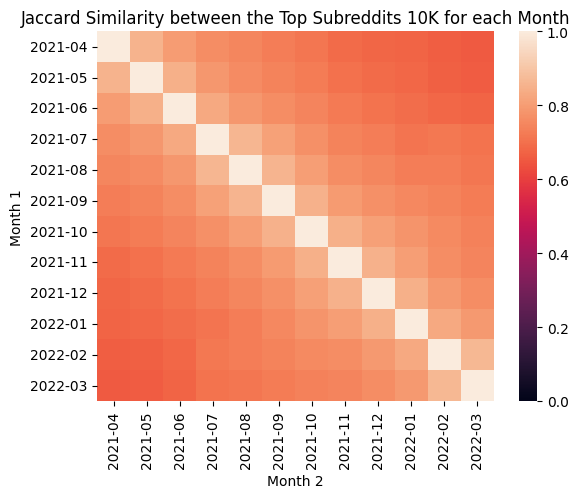

In [4]:
sns.heatmap(top_subreddit_ji_dataframe.pivot(index = "Month 1", columns = "Month 2", values = "Jaccard Index"), vmin=0, vmax=1).set_title("Jaccard Similarity between the Top Subreddits 10K for each Month")

Text(0.5, 1.0, 'Average Jaccard Similarity between the Top 20 Nearest Subreddits in the Community2vec Model for each Month')

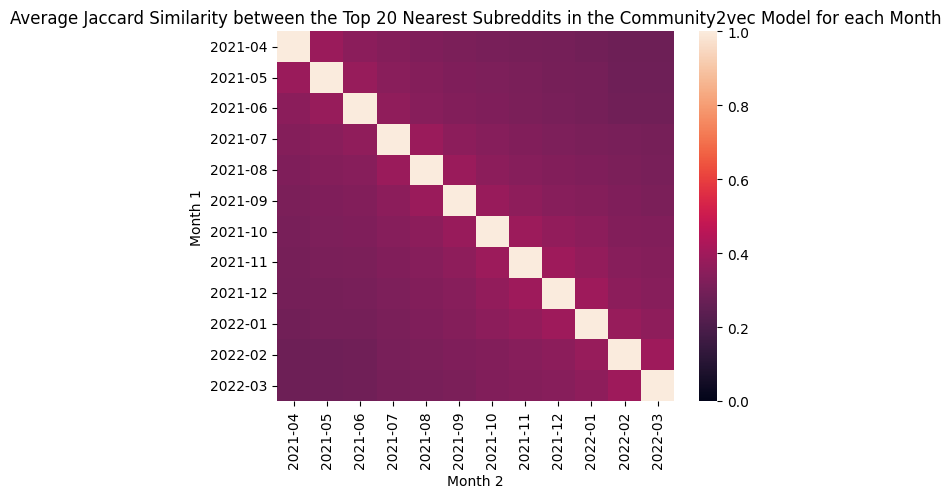

In [5]:
sns.heatmap(top_subreddit_ji_dataframe.pivot(index = "Month 1", columns = "Month 2", values = f"Community2vec Top {C2V_N_NEAREST_NEIGHBORS} Nearest Subreddit Neighbors Jaccard Index"), vmin=0, vmax=1).set_title(f"Average Jaccard Similarity between the Top {C2V_N_NEAREST_NEIGHBORS} Nearest Subreddits in the Community2vec Model for each Month")

The closer to 1 the values are, the more similar the top subreddits are between those two months. This plot shows that months closer in time have more top subreddits in common that months further apart in time. 

# Month-to-month K-means Cluster Stability Comparison
We'd like to measure how much variation there is between the k-means clusters of subreddits based on the community2vec embeddings created from each month of Reddit comment data. 

Here, we use a single community2vec model for each month (don't vary the community2vec models). Each month's community2vec model is used to train 10 k-means models where the random seed for the cluster model is varied, then the inter- and intra-month stability for each cluster model is measured. We also vary the number of clusters allowed for each. For each number of clusters, 

The intra-month values (training multiple k-means models from same community2vec model for a single month) will tell us how sensitive the k-means clusters are to random initialization within the same time range and community2vec model. We expect these values to be low relative to inter-month values. If they are high, it's an indication that the clusterings are sensitive to random initializations and indicates they may be difficult to use for research purposes. 

The inter-month values (training multiple k-means models for two separate months and doing many pairwise comparisons) will tell us how much the clusterings change over time. In most cases, we expect these values to be low when comparing two months that are close together in time, but higher for months that are far apart. In other words, these metrics should give an indication of how much Reddit clusterings change as time goes on. However, there's the possibility for these values to be high when drastic changes occur on Reddit, such as when certain subreddits spike in popularity or are banned. In such cases, the inter-month stability metrics could serve as an indicator of large changes in Reddit's "geography". 

In [6]:
# Num_clusters -> List of lists, where nested lists store paths to kmeans models for each month
metrics_collection = []
kmeans_models = defaultdict(list)
for month, c2v_model in zip(MONTHS, C2V_MODELS):
    print("Training clustering models for month:", month)
    vectors = c2v_model.w2v_model.wv
    data = c2v_model.get_normed_vectors()
    index = dict(enumerate(vectors.index_to_key))
    # Month path
    kmeans_month_path = STABILITY_METRICS_ROOT / f"{month}"
    kmeans_month_path.mkdir(parents=True, exist_ok=True)
    for n_clusters in NUM_CLUSTERS:
        kmeans_num_clusters_path = kmeans_month_path / f"{month}_numClusters{n_clusters}"
        current_month_batch_paths = []
        for i, seed in enumerate(RANDOM_SEEDS):
            this_kmeans_path = kmeans_num_clusters_path / f"{i}"
            current_month_batch_paths.append(this_kmeans_path)
            if not this_kmeans_path.exists():
                name = f"{month} KMeans model {n_clusters} clusters with random seed {seed}"
                #print("\tTraining", name)
                kmeans_model = ic.ClusteringModelFactory.init_clustering_model(model_choice = "kmeans", data=data, index=index, model_name=name, n_clusters=n_clusters, random_state = seed)
                kmeans_model.train()
                #print("\tSaving", name)
                kmeans_model.save(this_kmeans_path)
                metrics = kmeans_model.write_metrics((this_kmeans_path / "metrics.json"))
            else: 
                with (this_kmeans_path / "metrics.json").open(mode='r') as metrics_json:
                    metrics = json.load(metrics_json)

            metrics.update({"random_seed": seed, "experiment_id": i, "month": month, "n_clusters": n_clusters, "path": str(this_kmeans_path)})
            metrics_collection.append(metrics)
        kmeans_models[n_clusters].append(current_month_batch_paths)

kmeans_metrics_df = pd.DataFrame.from_records(metrics_collection)


Training clustering models for month: 2021-04
Training clustering models for month: 2021-05
Training clustering models for month: 2021-06
Training clustering models for month: 2021-07
Training clustering models for month: 2021-08
Training clustering models for month: 2021-09
Training clustering models for month: 2021-10
Training clustering models for month: 2021-11
Training clustering models for month: 2021-12
Training clustering models for month: 2022-01
Training clustering models for month: 2022-02
Training clustering models for month: 2022-03


In [7]:
display(kmeans_metrics_df)

Silhouette  Calinski-Harabasz  Davies-Bouldin  random_seed  \
0      0.102059          54.498023        3.077911            7   
1      0.099089          54.747398        3.140232           17   
2      0.098346          54.551313        3.143314           29   
3      0.105911          54.531143        3.082920           32   
4      0.103841          54.811491        3.087060           42   
..          ...                ...             ...          ...   
115    0.100469          55.823018        3.078728           53   
116    0.100529          55.895251        3.056993           63   
117    0.099570          55.968599        3.079239           70   
118    0.099790          55.922089        3.067835           84   
119    0.100423          55.898117        3.053116           96   

     experiment_id    month  n_clusters  \
0                0  2021-04         100   
1                1  2021-04         100   
2                2  2021-04         100   
3                3  2021-04         100   
4                4  2021-04         100   
..             ...      ...         ...   
115              5  2022-03         100   
116              6  2022-03         100   
117              7  2022-03         100   
118              8  2022-03         100   
119              9  2022-03         100   

                                                  path  
0    ../data/cluster_stability/2021-04/2021-04_numC...  
1    ../data/cluster_stability/2021-04/2021-04_numC...  
2    ../data/cluster_stability/2021-04/2021-04_numC...  
3    ../data/cluster_stability/2021-04/2021-04_numC...  
4    ../data/cluster_stability/2021-04/2021-04_numC...  
..                                                 ...  
115  ../data/cluster_stability/2022-03/2022-03_numC...  
116  ../data/cluster_stability/2022-03/2022-03_numC...  
117  ../data/cluster_stability/2022-03/2022-03_numC...  
118  ../data/cluster_stability/2022-03/2022-03_numC...  
119  ../data/cluster_stability/2022-03/2022-03_numC...  

[120 rows x 8 columns]

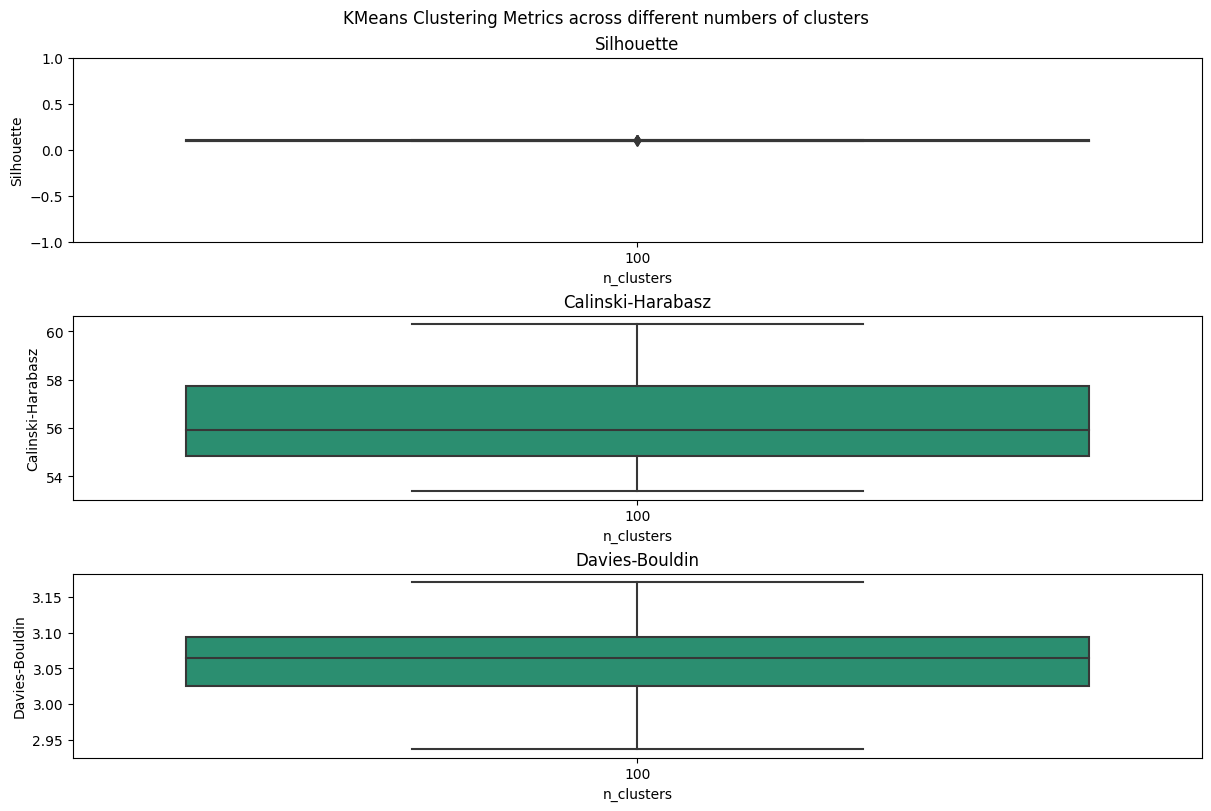

In [8]:
fig, axes = plt.subplots(ncols = 1, nrows=3, figsize=(12,8), constrained_layout=True)
fig.suptitle(f"KMeans Clustering Metrics across different numbers of clusters")
for i, metric_key in enumerate(["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]):
    if metric_key=="Silhouette":
        axes[i].set(ylim=(-1, 1))
    sns.boxplot(ax = axes[i], x="n_clusters", y=metric_key, order=NUM_CLUSTERS, data=kmeans_metrics_df)
    axes[i].set_title(metric_key)

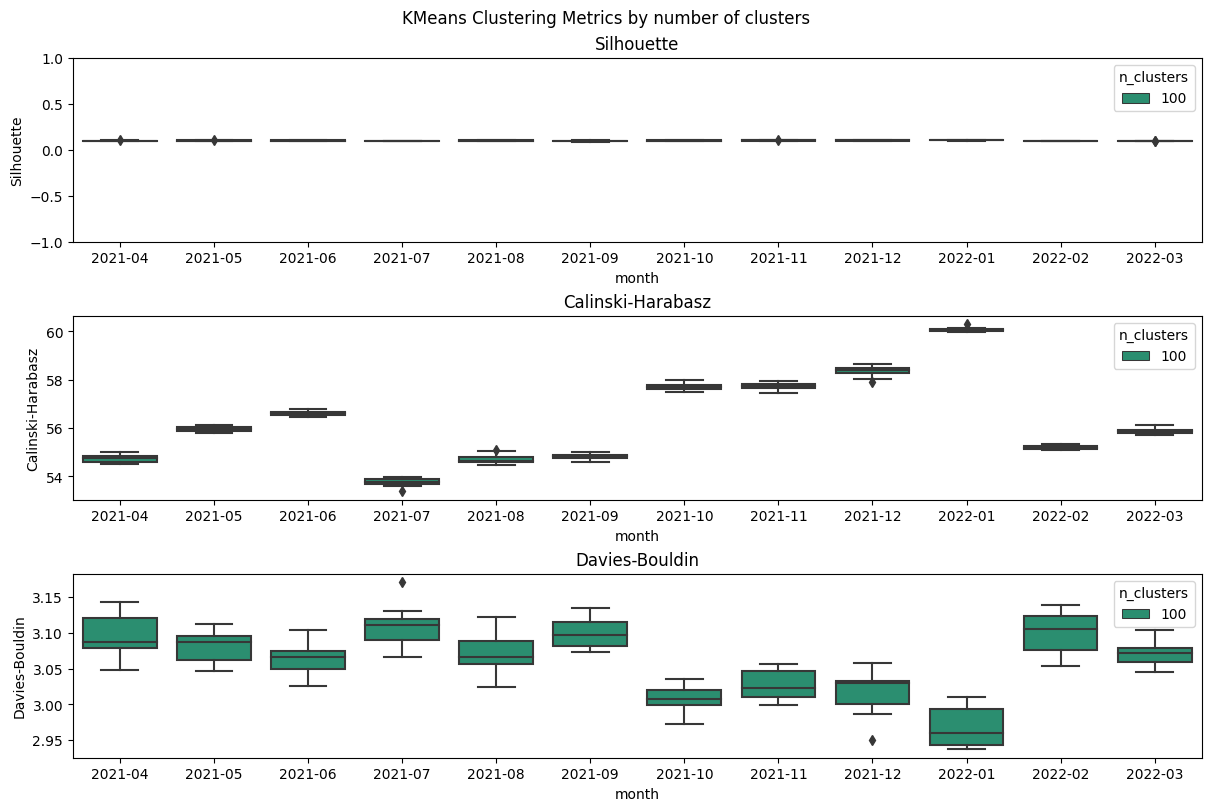

<Figure size 640x480 with 0 Axes>

In [9]:

fig, axes = plt.subplots(ncols = 1, nrows=3, figsize=(12,8), constrained_layout=True)
fig.suptitle(f"KMeans Clustering Metrics by number of clusters")
for i, metric_key in enumerate(["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]):
    if metric_key=="Silhouette":
        axes[i].set(ylim=(-1, 1))
    sns.boxplot(ax = axes[i], x="month", y=metric_key, order=MONTHS, data=kmeans_metrics_df, hue="n_clusters")
    axes[i].set_title(metric_key)
plt.show()
plt.clf()

In [10]:
# Actually computes the metrics that measure stability across time
# Pairwise comparison between KMeans cluster assignments of subreddits
all_comparison_results = []
comp_counter = 0
for n_clusters in NUM_CLUSTERS:
    print("Num clusters", n_clusters)
    # Compare month by month, experiment number i gets compared to all other experiments 
    # numbered i+1 or greater over all months
    for i1, month1 in enumerate(MONTHS):
        # Read in experiment 1 data
        month1_counts_dict = pd.read_csv(SUBREDDIT_COUNTS_CSVS[i1]).to_dict("records")
        month1_counts = {d["subreddit"]: d["count"] for d in month1_counts_dict}

        for exp_id1, seed in enumerate(RANDOM_SEEDS): 
            current_kmeans_path = STABILITY_METRICS_ROOT / f"{month1}" / f"{month1}_numClusters{n_clusters}" / str(exp_id1)
            current_kmeans_model = ic.ClusteringModel.load(current_kmeans_path, 
                C2V_MODELS[i1].get_normed_vectors(),
                C2V_MODELS[i1].get_index_as_dict(),
            )
            current_model_assignments = current_kmeans_model.get_cluster_assignments_as_dict()

            # Read in experiment 2 data
            for i2, month2 in enumerate(MONTHS):
                month2_counts_dict = pd.read_csv(SUBREDDIT_COUNTS_CSVS[i2]).to_dict("records")
                month2_counts = {d["subreddit"]: d["count"] for d in month2_counts_dict}

                # VI is symmetric, so index experiments so that you don't repeat comparisons or compare a model to itself
                for exp_id2 in range(exp_id1 + 1, len(RANDOM_SEEDS)):
                    kmeans_comparison_path = STABILITY_METRICS_ROOT / f"{month2}" / f"{month2}_numClusters{n_clusters}" / str(exp_id2)
                    kmeans_comparison_model = ic.ClusteringModel.load(
                        kmeans_comparison_path, 
                        C2V_MODELS[i2].get_normed_vectors(),
                        C2V_MODELS[i2].get_index_as_dict()
                        )
                    comparison_model_assignments = kmeans_comparison_model.get_cluster_assignments_as_dict()

                    # Compare the experiments and collect results
                    comparison_results = {"n_clusters":n_clusters, "month1": month1, "month1_experiment_id": exp_id1, "month2":month2, "month2_experiment_id":exp_id2 }
                    intersection_comparison_results = ic.compare_cluterings(current_model_assignments, comparison_model_assignments, use_union=False,
                    cluster_1_counts = month1_counts, 
                    cluster_2_counts = month2_counts)
                    comparison_results.update(intersection_comparison_results)

                    intersection_uniform_prob_results = ic.compare_cluterings(current_model_assignments, comparison_model_assignments, use_union=False)
                    comparison_results.update(intersection_uniform_prob_results)

                    union_comparison_results = ic.compare_cluterings(current_model_assignments, comparison_model_assignments, use_union=True,
                    cluster_1_counts = month1_counts, 
                    cluster_2_counts = month2_counts)
                    comparison_results.update(union_comparison_results)

                    all_comparison_results.append(comparison_results)
                    comp_counter+=1

cluster_comparison_df = pd.DataFrame.from_records(all_comparison_results)
display(cluster_comparison_df)


Num clusters 100


n_clusters   month1  month1_experiment_id   month2  \
0            100  2021-04                     0  2021-04   
1            100  2021-04                     0  2021-04   
2            100  2021-04                     0  2021-04   
3            100  2021-04                     0  2021-04   
4            100  2021-04                     0  2021-04   
...          ...      ...                   ...      ...   
6475         100  2022-03                     8  2021-11   
6476         100  2022-03                     8  2021-12   
6477         100  2022-03                     8  2022-01   
6478         100  2022-03                     8  2022-02   
6479         100  2022-03                     8  2022-03   

      month2_experiment_id  \
0                        1   
1                        2   
2                        3   
3                        4   
4                        5   
...                    ...   
6475                     9   
6476                     9   
6477                     9   
6478                     9   
6479                     9   

      intersection_comment_probability_variation_of_information  \
0                                              2.295443           
1                                              2.124403           
2                                              2.242683           
3                                              2.162557           
4                                              2.235574           
...                                                 ...           
6475                                           2.340920           
6476                                           2.470647           
6477                                           2.321625           
6478                                           2.295290           
6479                                           2.190339           

      intersection_uniform_probability_adjusted_rand_index  \
0                                              0.552522      
1                                              0.573216      
2                                              0.576330      
3                                              0.595701      
4                                              0.578812      
...                                                 ...      
6475                                           0.529873      
6476                                           0.522780      
6477                                           0.503368      
6478                                           0.524313      
6479                                           0.549994      

      intersection_uniform_probability_rand_index  \
0                                        0.989599   
1                                        0.990061   
2                                        0.989823   
3                                        0.990416   
4                                        0.990273   
...                                           ...   
6475                                     0.988959   
6476                                     0.988552   
6477                                     0.988397   
6478                                     0.988735   
6479                                     0.989457   

      intersection_uniform_probability_normalized_mutual_info  \
0                                              0.791565         
1                                              0.802826         
2                                              0.795944         
3                                              0.805103         
4                                              0.802525         
...                                                 ...         
6475                                           0.770833         
6476                                           0.768442         
6477                                           0.764599         
6478                                           0.770281         
6479                  

In [11]:
cluster_comparison_df.to_csv(STABILITY_METRICS_ROOT / "cluster_comparison_metrics.csv", index=False)

In [12]:
cluster_comparison_df = pd.read_csv(STABILITY_METRICS_ROOT / "cluster_comparison_metrics.csv")
display(cluster_comparison_df)

n_clusters   month1  month1_experiment_id   month2  \
0            100  2021-04                     0  2021-04   
1            100  2021-04                     0  2021-04   
2            100  2021-04                     0  2021-04   
3            100  2021-04                     0  2021-04   
4            100  2021-04                     0  2021-04   
...          ...      ...                   ...      ...   
6475         100  2022-03                     8  2021-11   
6476         100  2022-03                     8  2021-12   
6477         100  2022-03                     8  2022-01   
6478         100  2022-03                     8  2022-02   
6479         100  2022-03                     8  2022-03   

      month2_experiment_id  \
0                        1   
1                        2   
2                        3   
3                        4   
4                        5   
...                    ...   
6475                     9   
6476                     9   
6477                     9   
6478                     9   
6479                     9   

      intersection_comment_probability_variation_of_information  \
0                                              2.295443           
1                                              2.124403           
2                                              2.242683           
3                                              2.162557           
4                                              2.235574           
...                                                 ...           
6475                                           2.340920           
6476                                           2.470647           
6477                                           2.321625           
6478                                           2.295290           
6479                                           2.190339           

      intersection_uniform_probability_adjusted_rand_index  \
0                                              0.552522      
1                                              0.573216      
2                                              0.576330      
3                                              0.595701      
4                                              0.578812      
...                                                 ...      
6475                                           0.529873      
6476                                           0.522780      
6477                                           0.503368      
6478                                           0.524313      
6479                                           0.549994      

      intersection_uniform_probability_rand_index  \
0                                        0.989599   
1                                        0.990061   
2                                        0.989823   
3                                        0.990416   
4                                        0.990273   
...                                           ...   
6475                                     0.988959   
6476                                     0.988552   
6477                                     0.988397   
6478                                     0.988735   
6479                                     0.989457   

      intersection_uniform_probability_normalized_mutual_info  \
0                                              0.791565         
1                                              0.802826         
2                                              0.795944         
3                                              0.805103         
4                                              0.802525         
...                                                 ...         
6475                                           0.770833         
6476                                           0.768442         
6477                                           0.764599         
6478                                           0.770281         
6479                  

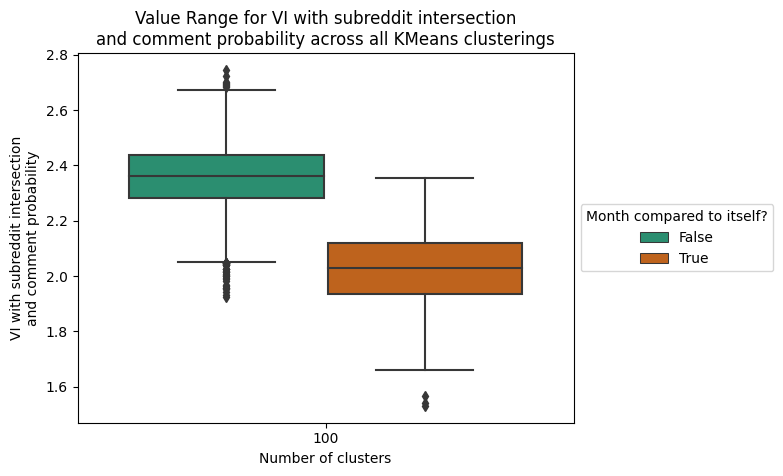

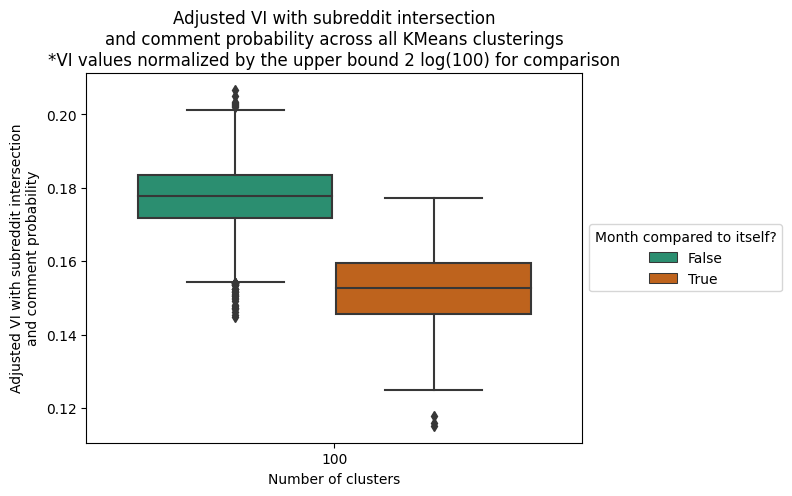

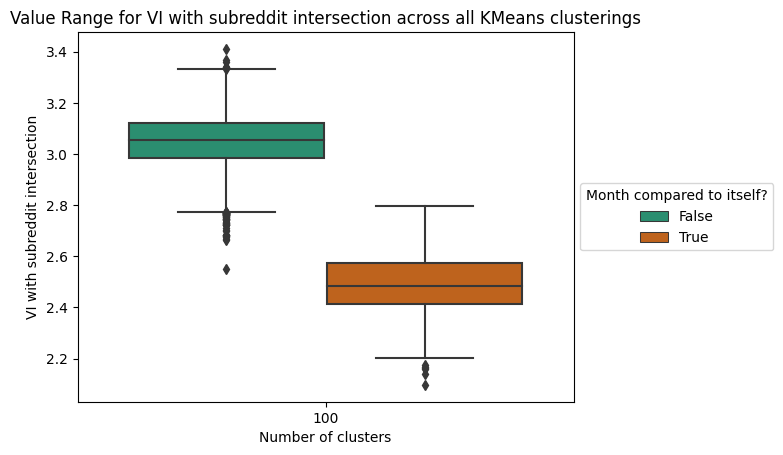

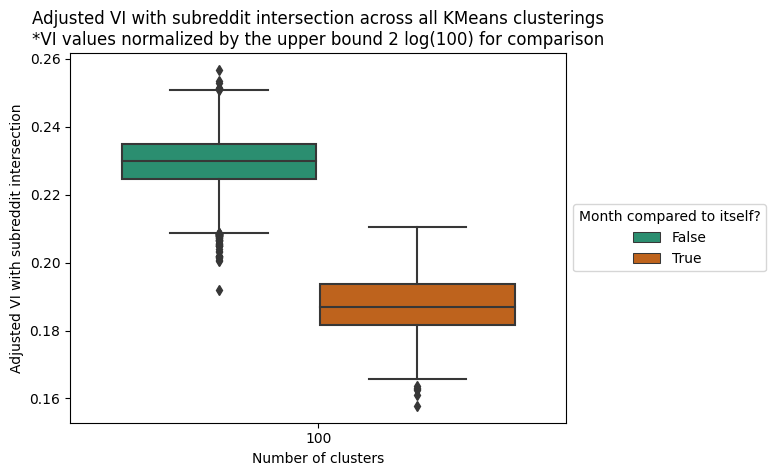

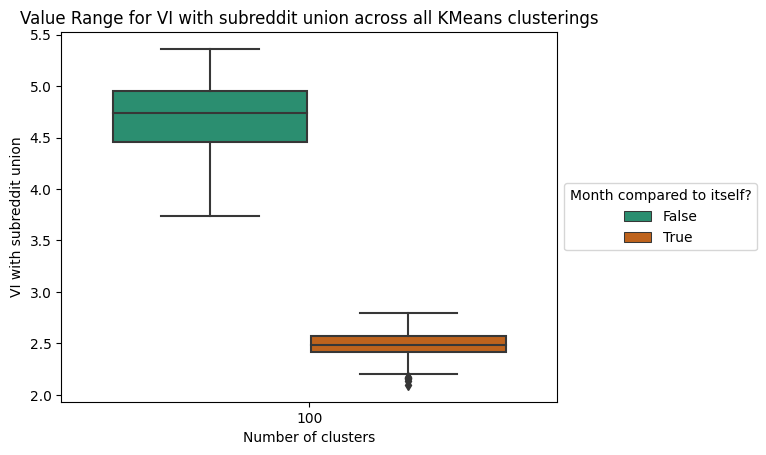

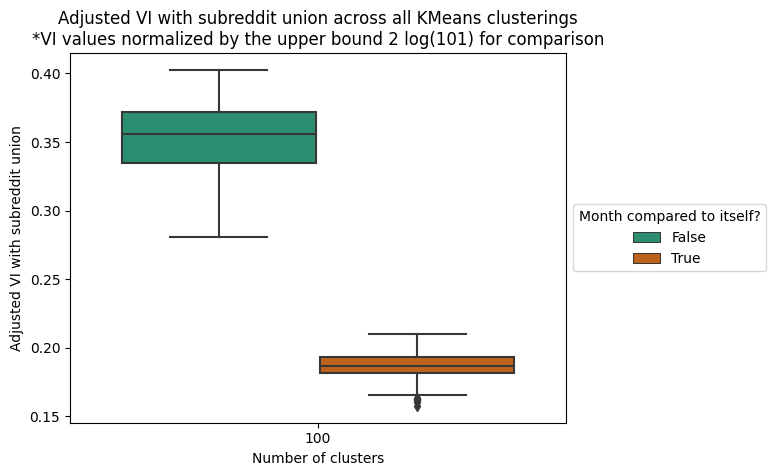

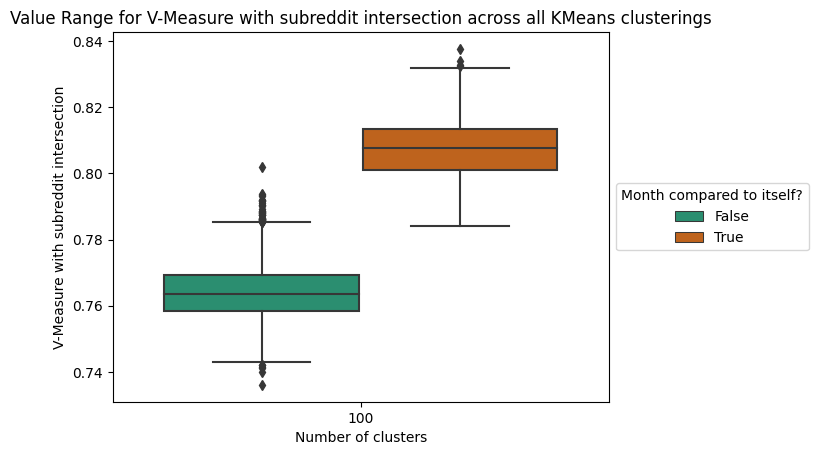

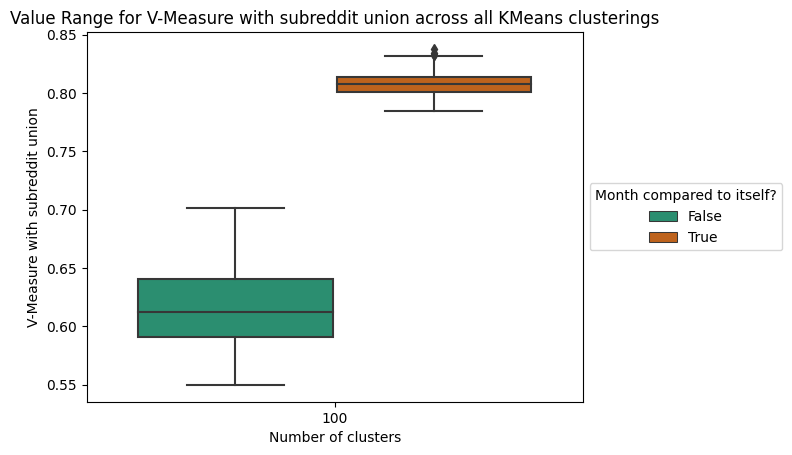

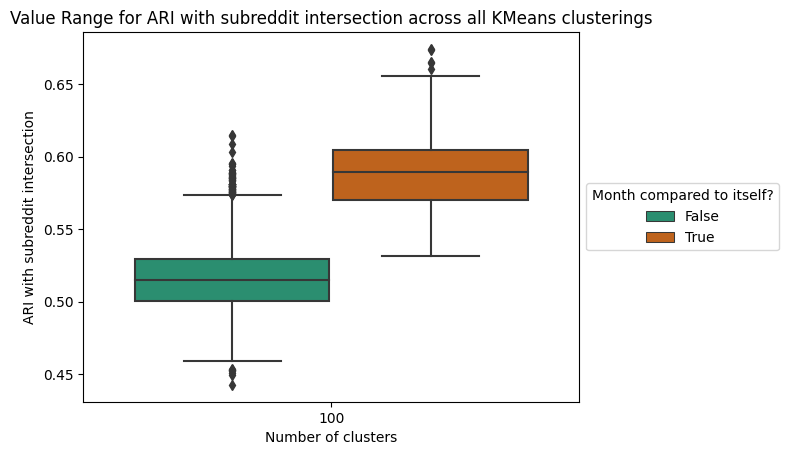

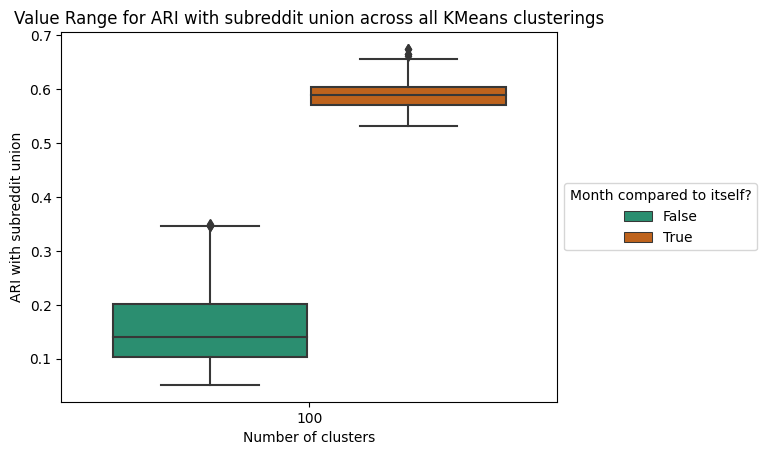

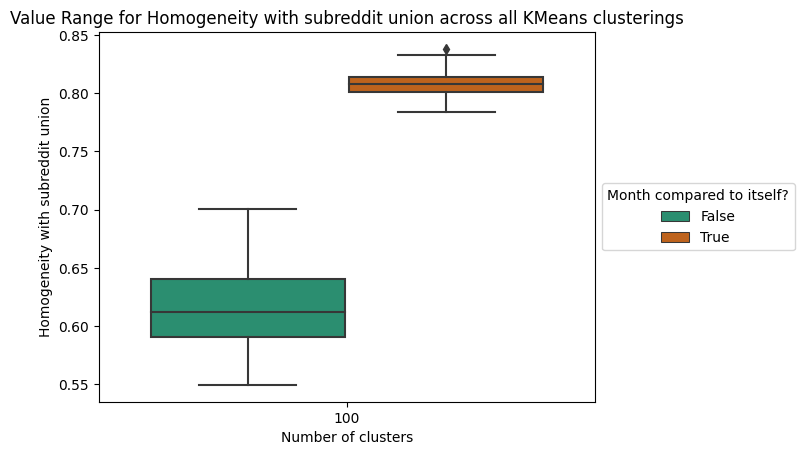

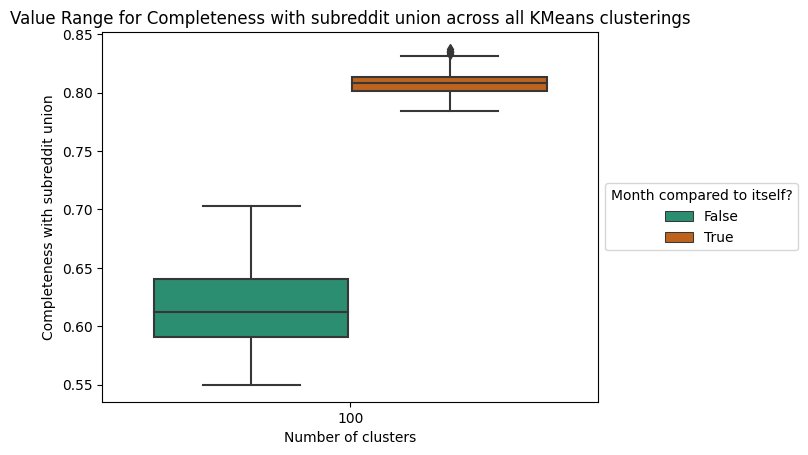

<Figure size 640x480 with 0 Axes>

In [13]:
max_n_clusters = max(NUM_CLUSTERS)
for cluster_comp_metric in ALL_CLUSTER_COMP_METRICS:
    n_cluster_experiments = cluster_comparison_df.copy()
    n_cluster_experiments["month compared to itself"] = n_cluster_experiments["month1"] == n_cluster_experiments["month2"]
    title_friendly_metric = VIZ_TITLES[cluster_comp_metric]
    title = f"Value Range for {title_friendly_metric} across all KMeans clusterings"
    ax = sns.boxplot(data=n_cluster_experiments, y=cluster_comp_metric, x="n_clusters", hue="month compared to itself")
    ax.set(ylabel=title_friendly_metric, title=title, xlabel="Number of clusters")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Month compared to itself?")
    plt.show()
    plt.clf()
    if "variation_of_information" in cluster_comp_metric:
        if "union" in cluster_comp_metric:
            rescale_val = max_n_clusters + 1
        else:
            rescale_val = max_n_clusters
        n_cluster_experiments["adjusted_" + cluster_comp_metric] = n_cluster_experiments[cluster_comp_metric] / (2*np.log2(rescale_val))
        title =f"Adjusted {title_friendly_metric} across all KMeans clusterings\n*VI values normalized by the upper bound 2 log({rescale_val}) for comparison"
        ax = sns.boxplot(data=n_cluster_experiments, y="adjusted_" + cluster_comp_metric, x="n_clusters", hue="month compared to itself")
        ax.set(ylabel=f"Adjusted {title_friendly_metric}", title=title, xlabel="Number of clusters")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Month compared to itself?")
        plt.show()
        plt.clf()



Num clusters: 100
intersection_comment_probability_variation_of_information theoretical max: 13.287712379549449


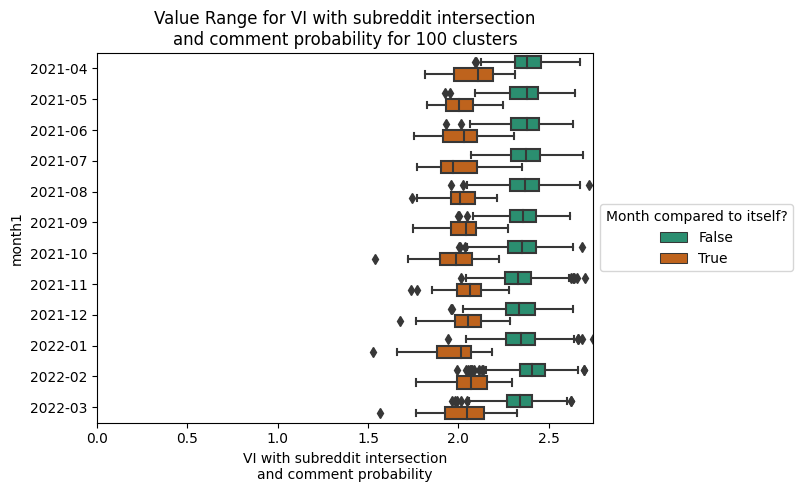

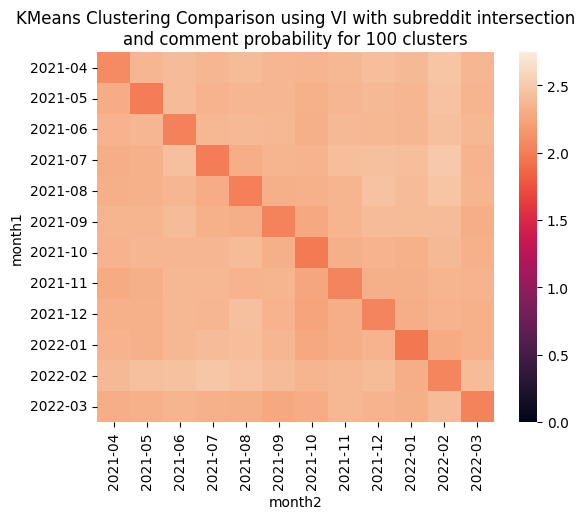

intersection_uniform_probability_variation_of_information theoretical max: 13.287712379549449


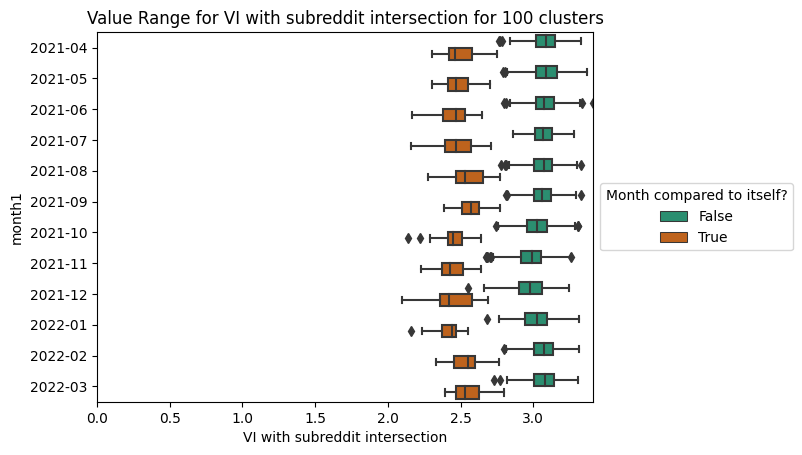

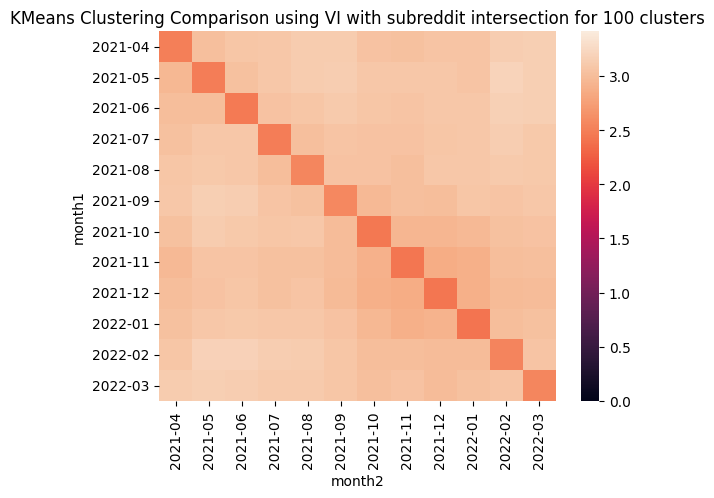

union_uniform_probability_variation_of_information theoretical max: 13.31642296550359


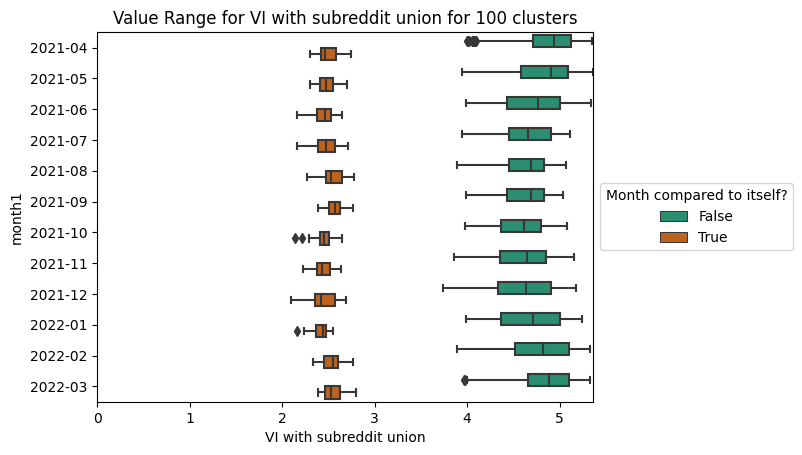

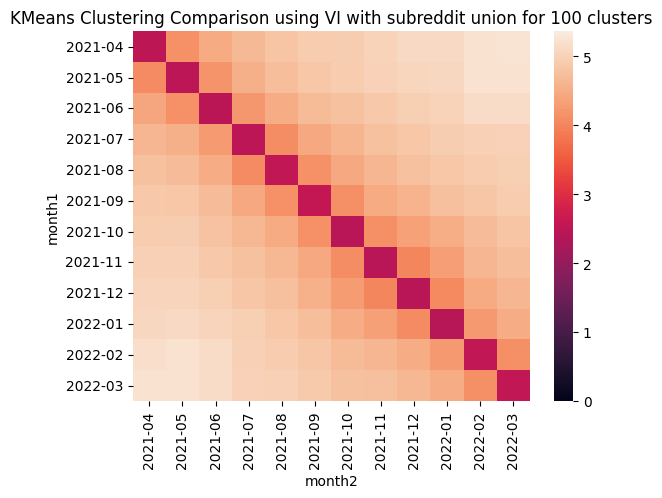

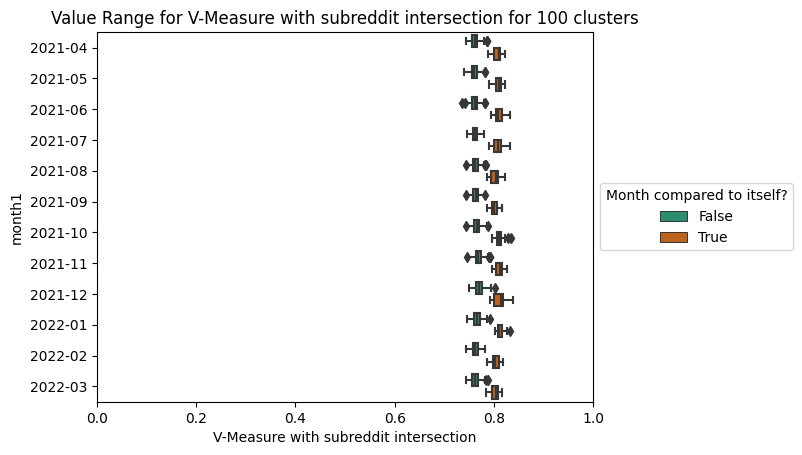

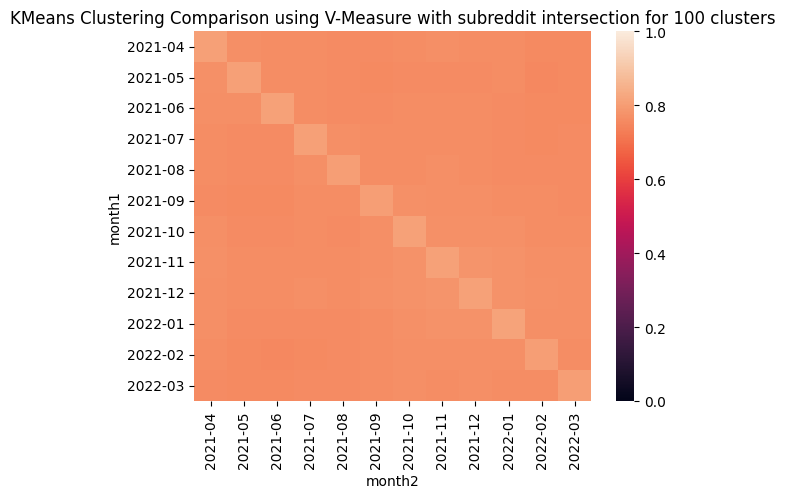

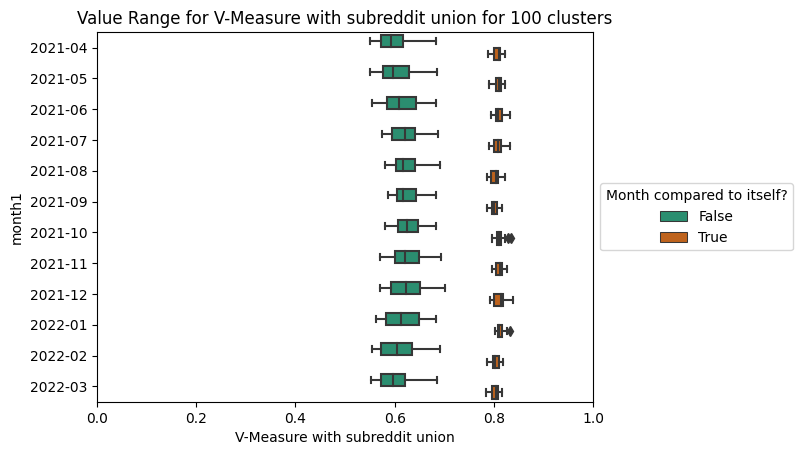

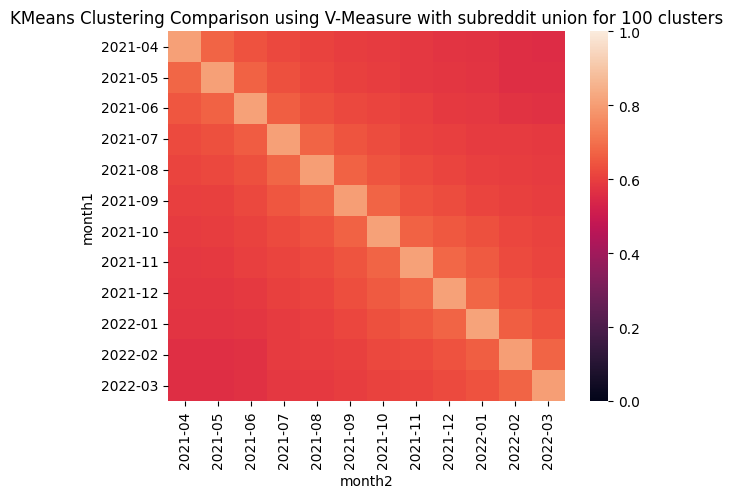

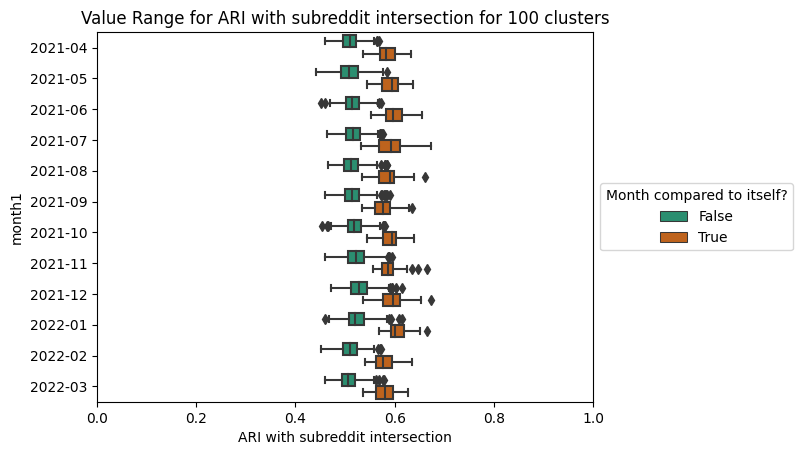

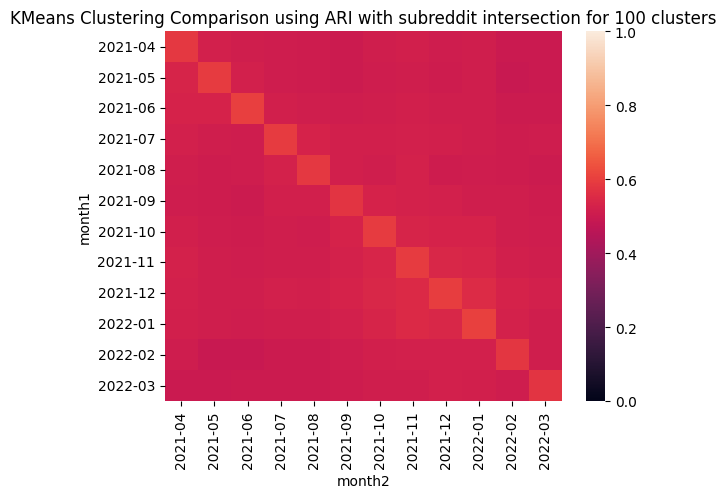

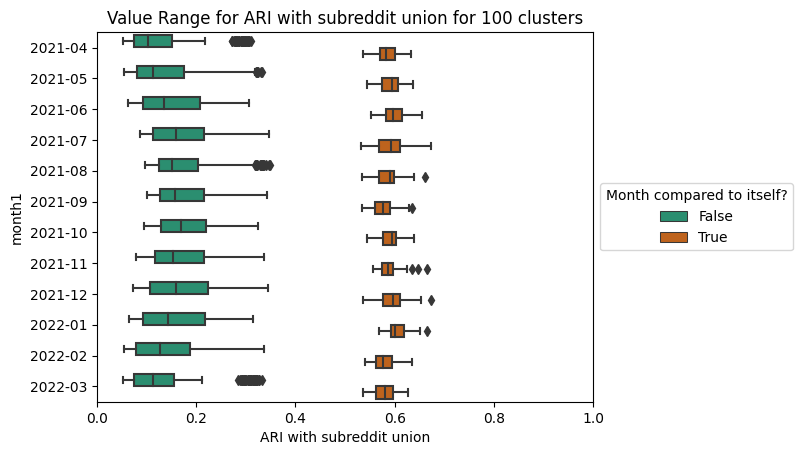

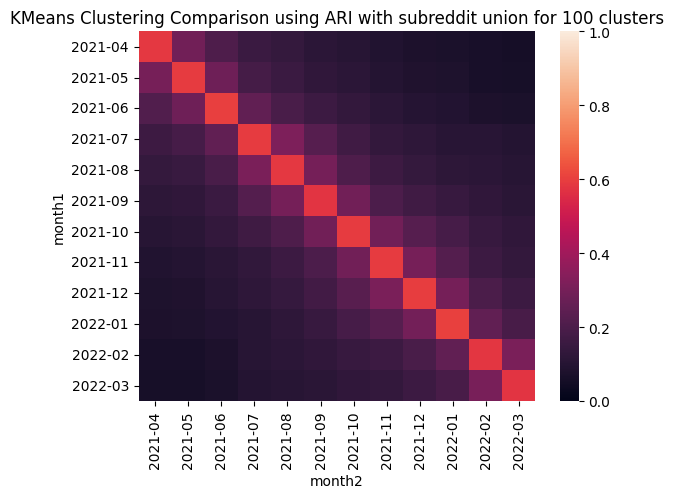

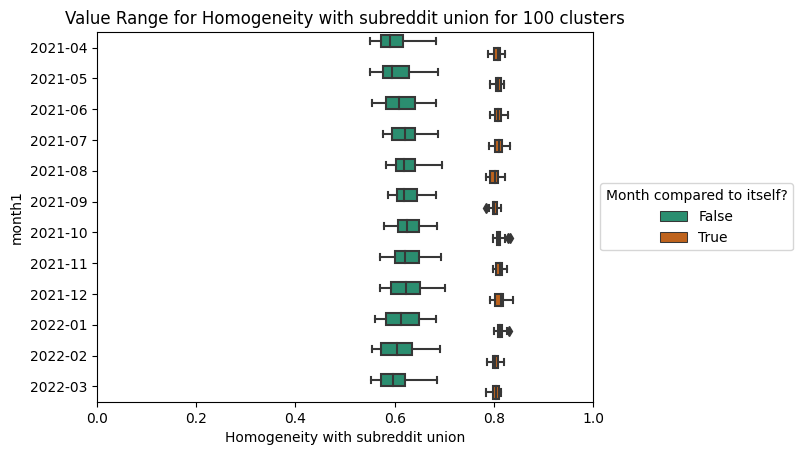

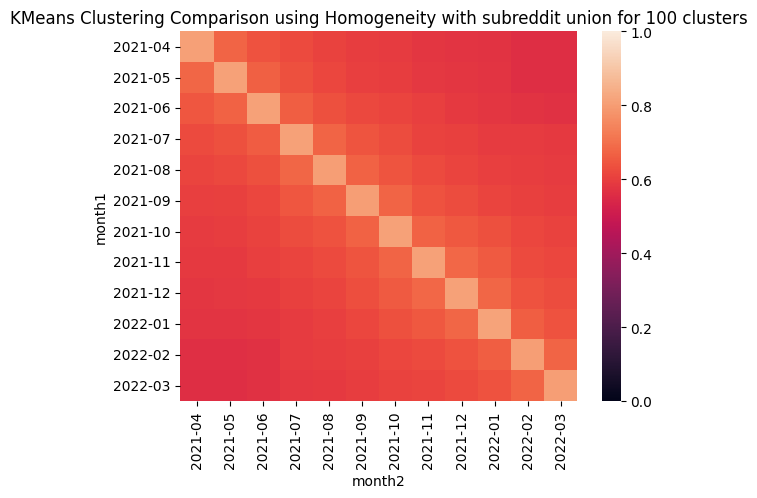

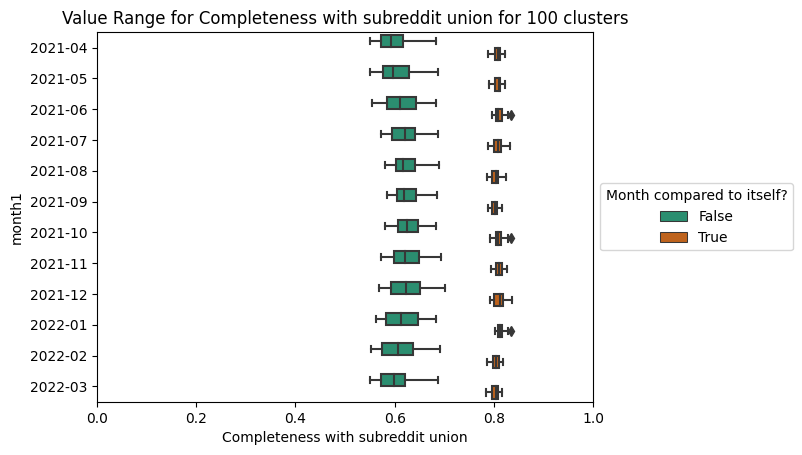

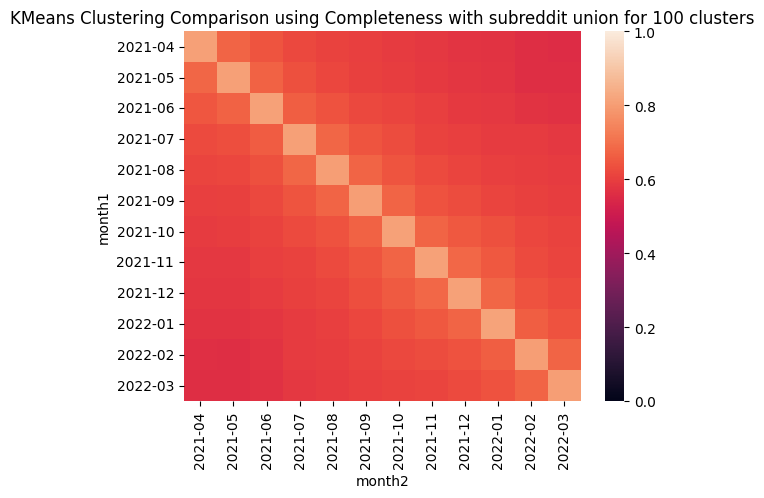

<Figure size 640x480 with 0 Axes>

In [14]:
for n_clusters in NUM_CLUSTERS:
    print("Num clusters:", n_clusters)
    for cluster_comp_metric in ALL_CLUSTER_COMP_METRICS:
        n_cluster_experiments = cluster_comparison_df[cluster_comparison_df["n_clusters"] == n_clusters].copy()
        vmin = 0
        if "variation_of_information" in cluster_comp_metric:
            # Compute the theoretical maximum
            # Max of VOI is 2 log K* when C_1 and C_2 both have at most K* clusters with K* <= sqrt(n)
            if "intersection" in cluster_comp_metric:
                tmax = 2*np.log2(n_clusters) 
                print(cluster_comp_metric, "theoretical max:", tmax)
            elif "union" in cluster_comp_metric:
                tmax = 2*np.log2(n_clusters+1)
                print(cluster_comp_metric, "theoretical max:", tmax)
                
            # But for visualizations, we want the actual maximum, because it makes the gradual changes more obvious
            vmax = n_cluster_experiments[cluster_comp_metric].max()
            
        if "variation_of_information" not in cluster_comp_metric:
            vmax=1
        n_cluster_experiments["month compared to itself"] = n_cluster_experiments["month1"] == n_cluster_experiments["month2"]
        title_friendly_metric = VIZ_TITLES[cluster_comp_metric]
        ax = sns.boxplot(data=n_cluster_experiments, x=cluster_comp_metric, y="month1", hue="month compared to itself")
        ax.set(title=f"Value Range for {title_friendly_metric} for {n_clusters} clusters", xlabel=title_friendly_metric)
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Month compared to itself?")
        plt.xlim(vmin, vmax)
        plt.show()
        plt.clf()
        ax = sns.heatmap(n_cluster_experiments.pivot_table(index="month1", columns="month2", values=cluster_comp_metric), vmin=vmin, vmax=vmax)
        ax.set(title=f"KMeans Clustering Comparison using {title_friendly_metric} for {n_clusters} clusters")
        plt.show()
        plt.clf()
    print()


# Month-to-month Hierarchical Cluster Stability Comparison
Similarly, we'd like to measure the inter-month stability of hierarchical agglomerative clusterings created from the community2vec data. Unlike K-means, hierarchical agglomerative clustering is not sensitive to initialization parameters, other than the user-defined choice of cluster size and linkage type, which determines how distance is computed between clusters. Thus, hierarchical agglomerative clustering is deterministic (except in case of ties in distances between clusters), so we only need to do a single inter-month comparison for each pair of months.

In [15]:
hac_metrics_collection = []
for month, c2v_model in zip(MONTHS, C2V_MODELS):
    print("Training agglomerative clustering models for month:", month)
    vectors = c2v_model.w2v_model.wv
    data = c2v_model.get_normed_vectors()
    index = dict(enumerate(vectors.index_to_key))
    # Month path
    agg_month_path = STABILITY_METRICS_ROOT / f"{month}"
    agg_month_path.mkdir(parents=True, exist_ok=True)
    
    for (link_type, n_clusters) in itertools.product(LINKAGE_TYPES, NUM_CLUSTERS):
        current_agg_model_path = agg_month_path / f"{month}_agglomerative_Linkage{link_type}_numClusters{n_clusters}"
        name = f"{month} Agglomerative Clustering {link_type} linkage {n_clusters} clusters"
        if not current_agg_model_path.exists(): 
            affinity="euclidean" if link_type=="ward" else "cosine"
            agg_model = ic.ClusteringModelFactory.init_clustering_model(model_choice = "agglomerative", data = data, index=index, model_name = name, n_clusters=n_clusters, linkage=link_type, affinity=affinity)
            agg_model.train()
            agg_model.save(current_agg_model_path)
            metrics = agg_model.get_metrics()
            with( current_agg_model_path / "metrics.json").open(mode='w') as metrics_json:
                json.dump(metrics, metrics_json, cls = ihop.utils.NumpyFloatEncoder)
        else: 
            print("\tModel", name, " appears to already exist")
            with (current_agg_model_path / "metrics.json").open(mode="r") as metrics_json:
                metrics = json.load(metrics_json)
        metrics.update({"linkage": link_type, "path":str(current_agg_model_path), "month":month, "n_clusters": n_clusters})
        hac_metrics_collection.append(metrics)
    
hac_metrics_df = pd.DataFrame.from_records(hac_metrics_collection)
display(hac_metrics_df) 

Training agglomerative clustering models for month: 2021-04
	Model 2021-04 Agglomerative Clustering complete linkage 100 clusters  appears to already exist
	Model 2021-04 Agglomerative Clustering average linkage 100 clusters  appears to already exist
	Model 2021-04 Agglomerative Clustering ward linkage 100 clusters  appears to already exist
Training agglomerative clustering models for month: 2021-05
	Model 2021-05 Agglomerative Clustering complete linkage 100 clusters  appears to already exist
	Model 2021-05 Agglomerative Clustering average linkage 100 clusters  appears to already exist
	Model 2021-05 Agglomerative Clustering ward linkage 100 clusters  appears to already exist
Training agglomerative clustering models for month: 2021-06
	Model 2021-06 Agglomerative Clustering complete linkage 100 clusters  appears to already exist
	Model 2021-06 Agglomerative Clustering average linkage 100 clusters  appears to already exist
	Model 2021-06 Agglomerative Clustering ward linkage 100 cluste

Silhouette  Calinski-Harabasz  Davies-Bouldin   linkage  \
0     0.046809          40.225900        3.653925  complete   
1     0.066528          33.063556        2.358039   average   
2     0.064037          49.362964        3.229816      ward   
3     0.046243          40.891053        3.518757  complete   
4     0.073714          34.945164        2.261186   average   
5     0.072897          50.552269        3.239835      ward   
6     0.058607          43.311300        3.367860  complete   
7     0.075900          35.084774        2.312386   average   
8     0.070851          51.059919        3.224671      ward   
9     0.043407          39.327126        3.718022  complete   
10    0.068912          33.722412        2.419915   average   
11    0.070303          48.811164        3.276994      ward   
12    0.060460          40.663131        3.569034  complete   
13    0.077123          35.328371        2.431259   average   
14    0.067894          49.546150        3.220799      ward   
15    0.048884          41.148228        3.667097  complete   
16    0.067243          31.815391        2.161236   average   
17    0.075111          49.897169        3.174120      ward   
18    0.058907          42.699270        3.311596  complete   
19    0.066482          31.352101        1.950425   average   
20    0.078047          52.837229        3.145792      ward   
21    0.061573          41.363316        3.220458  complete   
22    0.072943          31.233401        1.930643   average   
23    0.067938          52.434671        3.131614      ward   
24    0.050123          41.079226        3.303233  complete   
25    0.068666          30.839873        1.903356   average   
26    0.075852          52.920631        3.078994      ward   
27    0.065819          42.070394        3.189478  complete   
28    0.073673          33.118172        1.952637   average   
29    0.079756          54.457741        3.064340      ward   
30    0.042569          39.944631        3.443745  complete   
31    0.068205          31.583154        2.033126   average   
32    0.068805          50.199035        3.226589      ward   
33    0.053131          41.575725        3.513825  complete   
34    0.068364          33.617396        2.261072   average   
35    0.069718          50.874522        3.194436      ward   

                                                 path    month  n_clusters  
0   ../data/cluster_stability/2021-04/2021-04_aggl...  2021-04         100  
1   ../data/cluster_stability/2021-04/2021-04_aggl...  2021-04         100  
2   ../data/cluster_stability/2021-04/2021-04_aggl...  2021-04         100  
3   ../data/cluster_stability/2021-05/2021-05_aggl...  2021-05         100  
4   ../data/cluster_stability/2021-05/2021-05_aggl...  2021-05         100  
5   ../data/cluster_stability/2021-05/2021-05_aggl...  2021-05         100  
6   ../data/cluster_stability/2021-06/2021-06_aggl...  2021-06         100  
7   ../data/cluster_stability/2021-06/2021-06_aggl...  2021-06         100  
8   ../data/cluster_stability/2021-06/2021-06_aggl...  2021-06         100  
9   ../data/cluster_stability/2021-07/2021-07_aggl...  2021-07         100  
10  ../data/cluster_stability/2021-07/2021-07_aggl...  2021-07         100  
11  ../data/cluster_stability/2021-07/2021-07_aggl...  2021-07         100  
12  ../data/cluster_stability/2021-08/2021-08_aggl...  2021-08         100  
13  ../data/cluster_stability/2021-08/2021-08_aggl...  2021-08         100  
14  ../data/cluster_stability/2021-08/2021-08_aggl...  2021-08         100  
15  ../data/cluster_stability/2021-09/2021-09_aggl...  2021-09         100  
16  ../data/cluster_stability/2021-09/2021-09_aggl...  2021-09         100  
17  ../data/cluster_stability/2021-09/2021-09_aggl...  2021-09         100  
18  ../data/cluster_stability/2021-10/2021-10_aggl...  2021-10         100  
19  ../data/cluster_stability/2021-10/2021-10_aggl...  2021-10         100  
20  ../data/cluster_stability/2021-10/2021-10_aggl...  

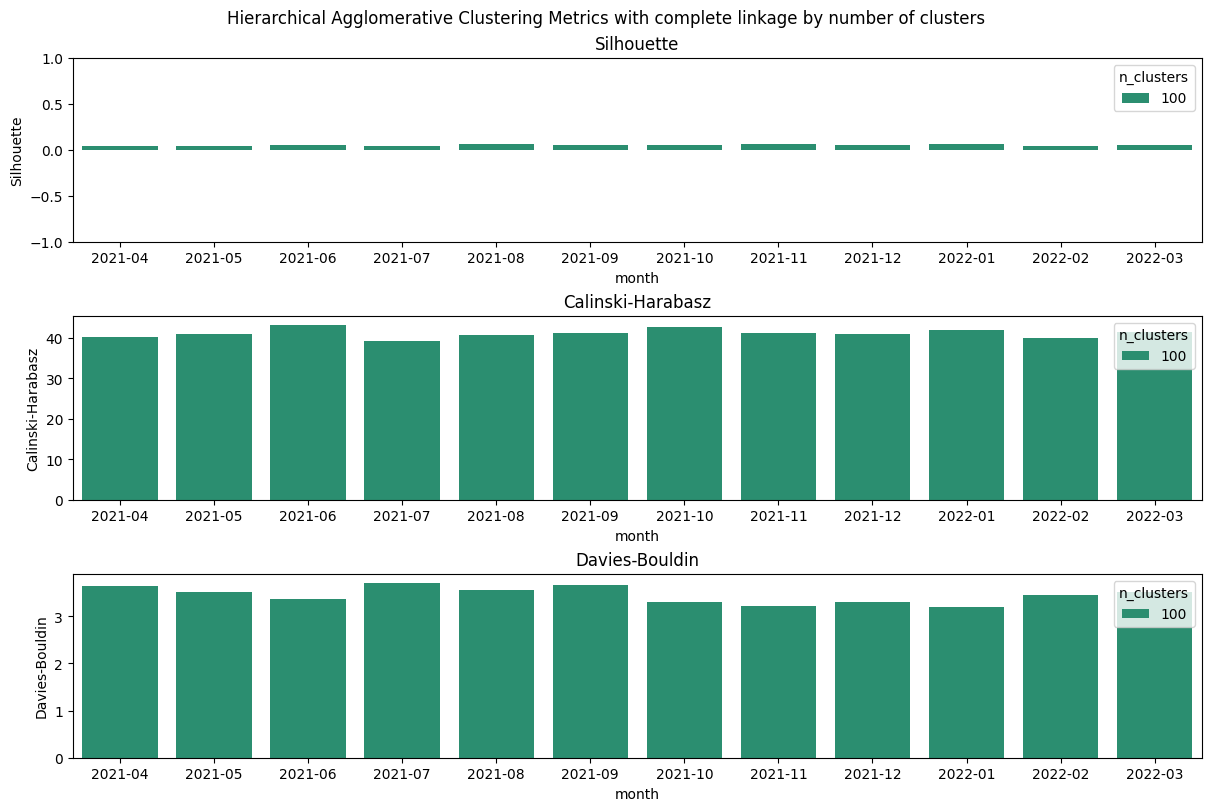

<Figure size 640x480 with 0 Axes>

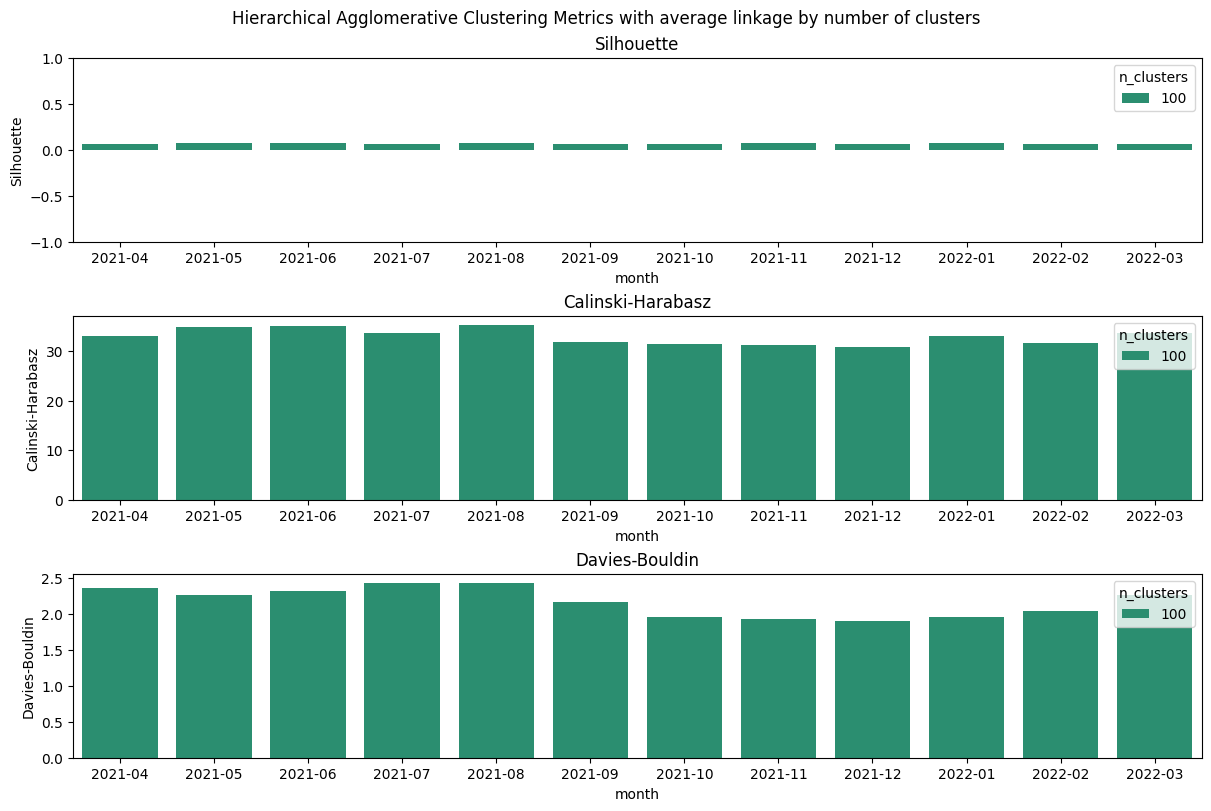

<Figure size 640x480 with 0 Axes>

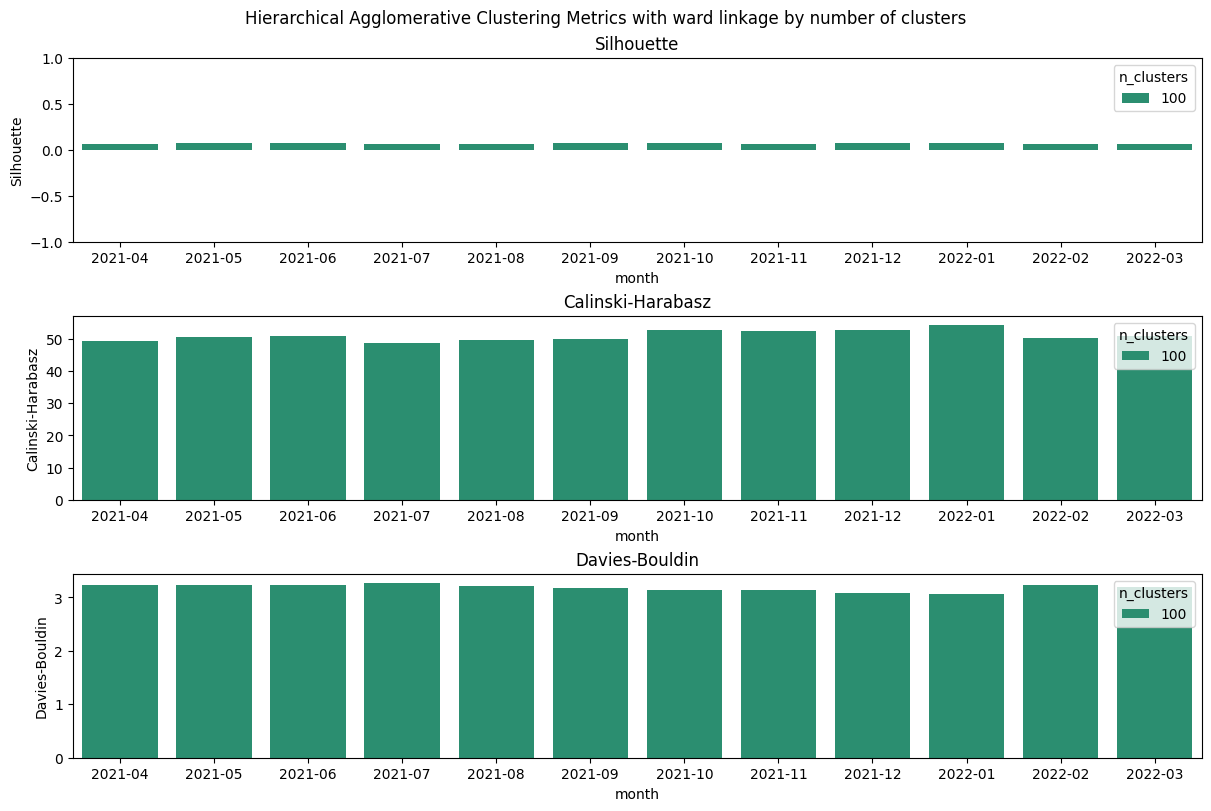

<Figure size 640x480 with 0 Axes>

In [16]:
for l in LINKAGE_TYPES:
    fig, axes = plt.subplots(ncols = 1, nrows=3, figsize=(12,8), constrained_layout=True)
    fig.suptitle(f"Hierarchical Agglomerative Clustering Metrics with {l} linkage by number of clusters")
    tmp_linkage_df =hac_metrics_df[hac_metrics_df["linkage"]==l]
    for i, metric_key in enumerate(["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]):
        if metric_key=="Silhouette":
            axes[i].set(ylim=(-1, 1))
        sns.barplot(ax = axes[i], x="month", y=metric_key, order=MONTHS, data=tmp_linkage_df, hue="n_clusters")
        axes[i].set_title(metric_key)
    plt.show()
    plt.clf()


In [17]:
# Pairwise comparison between HAC assignments of subreddits
all_hac_comparison_results = []
comp_counter = 0
for (l, num_clusters) in itertools.product(LINKAGE_TYPES, NUM_CLUSTERS):
    print("Linkage type:", l, ", Num clusters:", num_clusters)
    # Compare month by month, experiment number i gets compared to all other experiments 
    # numbered i+1 or greater over all months
    for i1, month1 in enumerate(MONTHS):
        # Read in experiment 1 data
        month1_counts_dict = pd.read_csv(SUBREDDIT_COUNTS_CSVS[i1]).to_dict("records")
        month1_counts = {d["subreddit"]: d["count"] for d in month1_counts_dict}
    
        current_hac_path = STABILITY_METRICS_ROOT / f"{month1}" / f"{month1}_agglomerative_Linkage{l}_numClusters{num_clusters}" 
        current_hac_model = ic.ClusteringModel.load(current_hac_path, 
            C2V_MODELS[i1].get_normed_vectors(),
            C2V_MODELS[i1].get_index_as_dict(),
        )
        current_model_assignments = current_hac_model.get_cluster_assignments_as_dict()

        # Read in experiment 2 data
        for i2, month2 in enumerate(MONTHS):
            month2_counts_dict = pd.read_csv(SUBREDDIT_COUNTS_CSVS[i2]).to_dict("records")
            month2_counts = {d["subreddit"]: d["count"] for d in month2_counts_dict}
            hac_comparison_path = STABILITY_METRICS_ROOT / f"{month2}" / f"{month2}_agglomerative_Linkage{l}_numClusters{num_clusters}" 
            hac_comparison_model = ic.ClusteringModel.load(
                hac_comparison_path, 
                C2V_MODELS[i2].get_normed_vectors(),
                C2V_MODELS[i2].get_index_as_dict()
                )
            comparison_model_assignments = hac_comparison_model.get_cluster_assignments_as_dict()

            # Compare the experiments and collect results
            comparison_results = {"linkage":l, "num_clusters": num_clusters, "month1": month1, "month2":month2}
            intersection_comparison_results = ic.compare_cluterings(current_model_assignments, comparison_model_assignments, use_union=False,
            cluster_1_counts = month1_counts, 
            cluster_2_counts = month2_counts)
            comparison_results.update(intersection_comparison_results)

            intersection_uniform_prob_results = ic.compare_cluterings(current_model_assignments, comparison_model_assignments, use_union=False)
            comparison_results.update(intersection_uniform_prob_results)

            union_comparison_results = ic.compare_cluterings(current_model_assignments, comparison_model_assignments, use_union=True,
            cluster_1_counts = month1_counts, 
            cluster_2_counts = month2_counts)
            comparison_results.update(union_comparison_results)

            all_hac_comparison_results.append(comparison_results)

hac_cluster_comparison_df = pd.DataFrame.from_records(all_hac_comparison_results)
display(hac_cluster_comparison_df)

Linkage type: complete , Num clusters: 100
Linkage type: average , Num clusters: 100
Linkage type: ward , Num clusters: 100


linkage  num_clusters   month1   month2  \
0    complete           100  2021-04  2021-04   
1    complete           100  2021-04  2021-05   
2    complete           100  2021-04  2021-06   
3    complete           100  2021-04  2021-07   
4    complete           100  2021-04  2021-08   
..        ...           ...      ...      ...   
427      ward           100  2022-03  2021-11   
428      ward           100  2022-03  2021-12   
429      ward           100  2022-03  2022-01   
430      ward           100  2022-03  2022-02   
431      ward           100  2022-03  2022-03   

     intersection_comment_probability_variation_of_information  \
0                                             0.000000           
1                                             3.655825           
2                                             3.591814           
3                                             3.635088           
4                                             3.508190           
..                                                 ...           
427                                           2.255119           
428                                           2.135687           
429                                           2.300276           
430                                           2.183485           
431                                           0.000000           

     intersection_uniform_probability_adjusted_rand_index  \
0                                             1.000000      
1                                             0.321708      
2                                             0.338732      
3                                             0.305528      
4                                             0.345944      
..                                                 ...      
427                                           0.477277      
428                                           0.559210      
429                                           0.473103      
430                                           0.531520      
431                                           1.000000      

     intersection_uniform_probability_rand_index  \
0                                       1.000000   
1                                       0.975147   
2                                       0.975976   
3                                       0.976931   
4                                       0.975673   
..                                           ...   
427                                     0.986156   
428                                     0.987852   
429                                     0.986080   
430                                     0.987149   
431                                     1.000000   

     intersection_uniform_probability_normalized_mutual_info  \
0                                             1.000000         
1                                             0.623955         
2                                             0.631873         
3                                             0.620531         
4                                             0.625024         
..                                                 ...         
427                                           0.757499         
428                                           0.766794         
429                                           0.755671         
430                                           0.763235         
431                                           1.000000         

     intersection_uniform_probability_homogeneity  \
0                                        1.000000   
1                                        0.620058   
2                                        0.628373   
3                                        0.618880   
4                                        0.619207   
..                                            ...   
427                                      0.757153   
428                                      0.765125   
429                 

In [18]:
hac_cluster_comparison_df.to_csv(STABILITY_METRICS_ROOT / "hac_cluster_comparison_metrics.csv", index=False)

month1   month2   linkage  num_clusters  \
0    2021-04  2021-05  complete           100   
1    2021-04  2021-05   average           100   
2    2021-04  2021-05      ward           100   
3    2021-04  2021-06  complete           100   
4    2021-04  2021-06   average           100   
..       ...      ...       ...           ...   
193  2022-01  2022-03   average           100   
194  2022-01  2022-03      ward           100   
195  2022-02  2022-03  complete           100   
196  2022-02  2022-03   average           100   
197  2022-02  2022-03      ward           100   

     intersection_comment_probability_variation_of_information  \
0                                             3.655825           
1                                             2.100674           
2                                             2.429435           
3                                             3.591814           
4                                             2.142844           
..                                                 ...           
193                                           2.019698           
194                                           2.300276           
195                                           3.562852           
196                                           1.963522           
197                                           2.183485           

     intersection_uniform_probability_adjusted_rand_index  \
0                                             0.321708      
1                                             0.622526      
2                                             0.444160      
3                                             0.338732      
4                                             0.617405      
..                                                 ...      
193                                           0.657271      
194                                           0.473103      
195                                           0.367867      
196                                           0.699711      
197                                           0.531520      

     intersection_uniform_probability_rand_index  \
0                                       0.975147   
1                                       0.962693   
2                                       0.985675   
3                                       0.975976   
4                                       0.962112   
..                                           ...   
193                                     0.960575   
194                                     0.986080   
195                                     0.976250   
196                                     0.966435   
197                                     0.987149   

     intersection_uniform_probability_normalized_mutual_info  \
0                                             0.623955         
1                                             0.735605         
2                                             0.750266         
3                                             0.631873         
4                                             0.734923         
..                                                 ...         
193                                           0.738906         
194                                           0.755671         
195                                           0.623947         
196                                           0.741463         
197                                           0.763235         

     intersection_uniform_probability_homogeneity  \
0                                        0.620058   
1                                        0.740428   
2                                        0.749705   
3                                        0.628373   
4                                        0.741136   
..                                            ...   
193                                      0.760205   
194                                      0.756363   
195                 

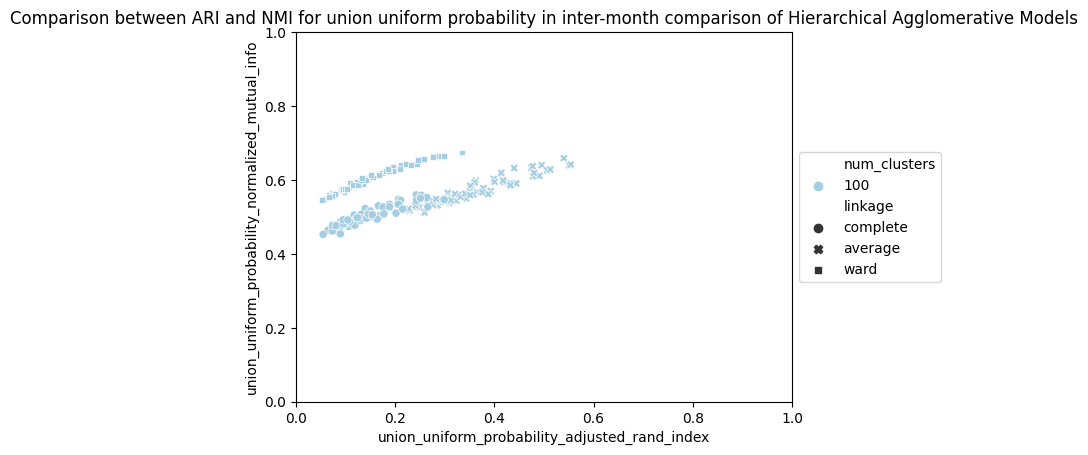

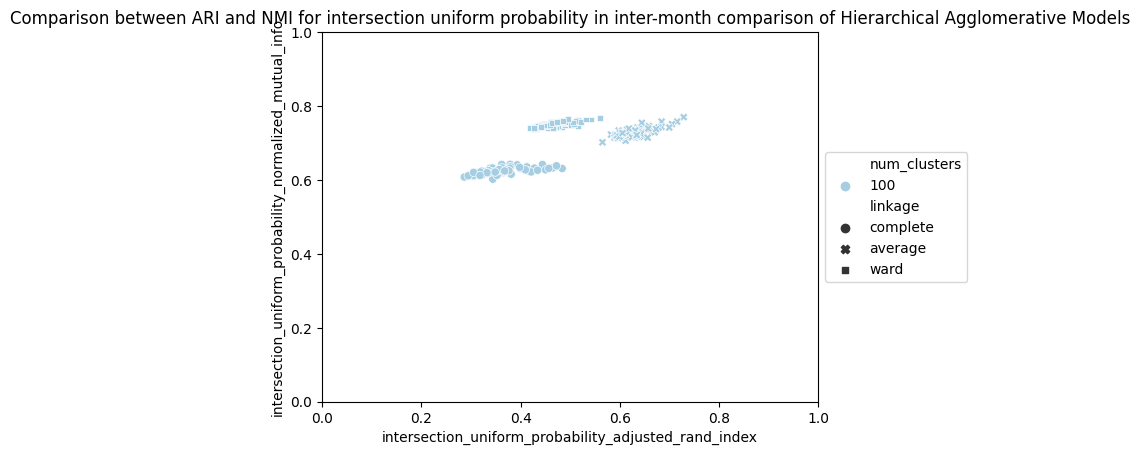

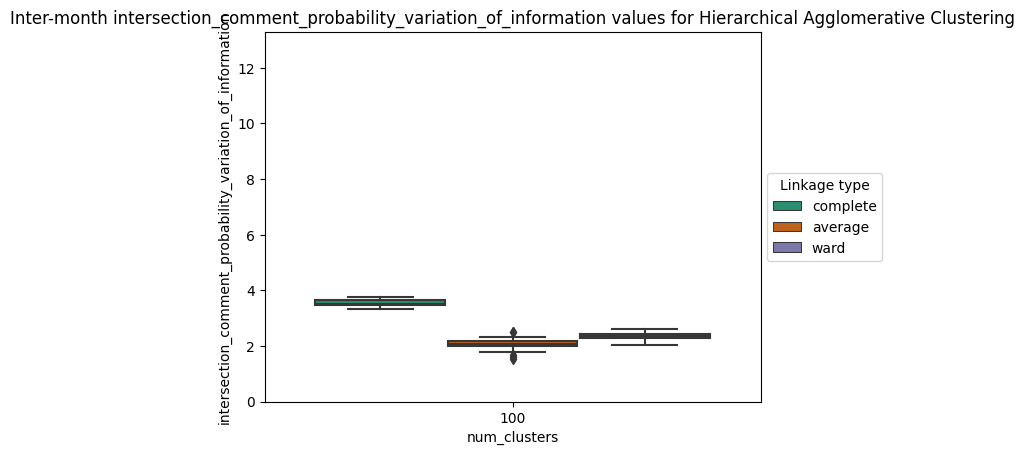

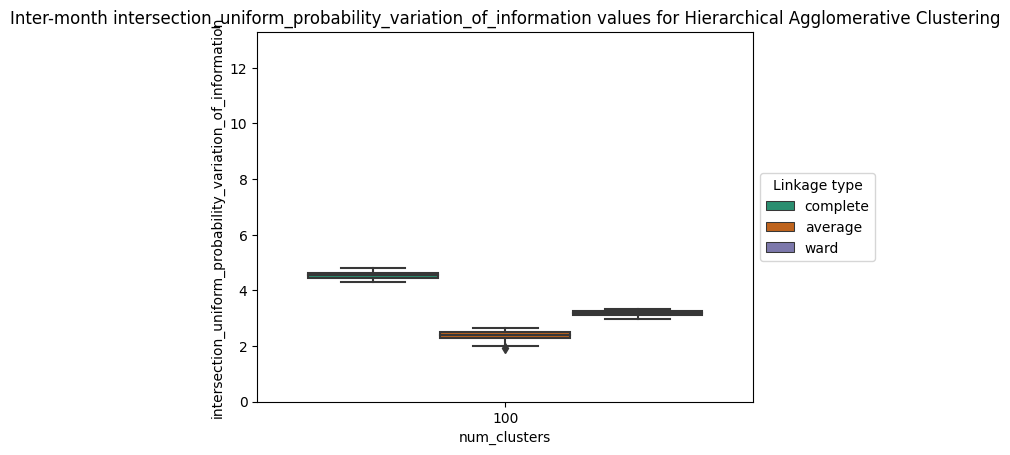

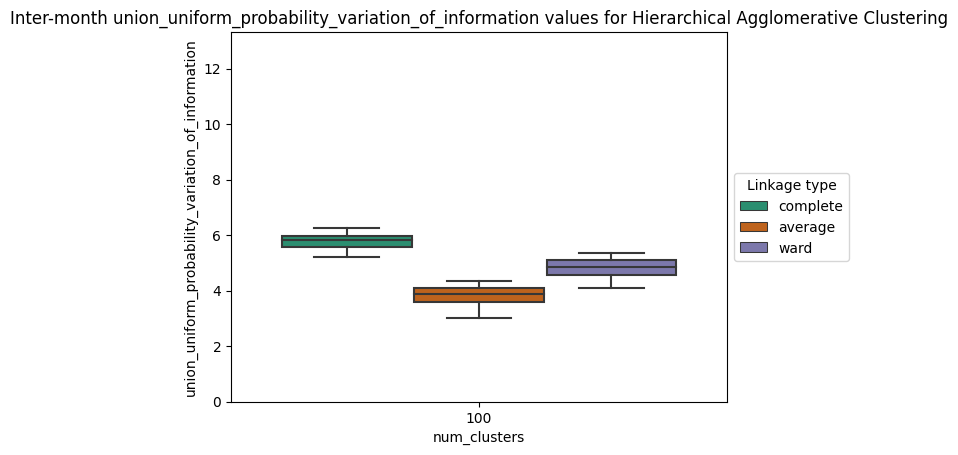

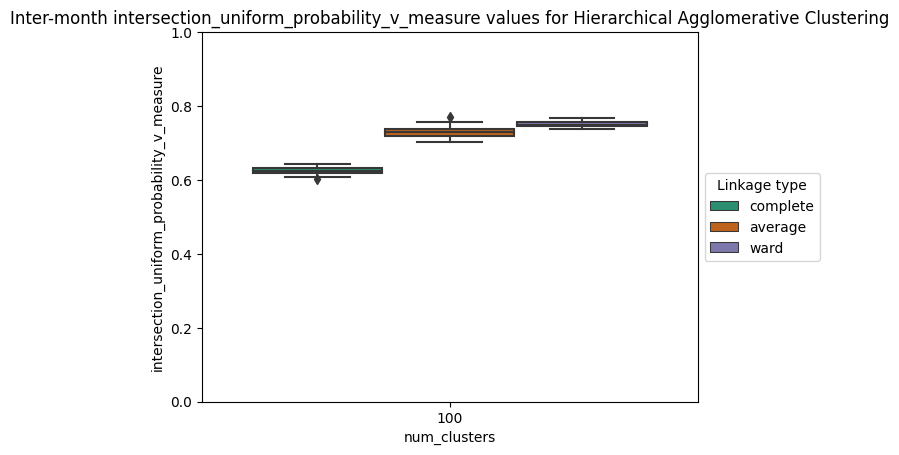

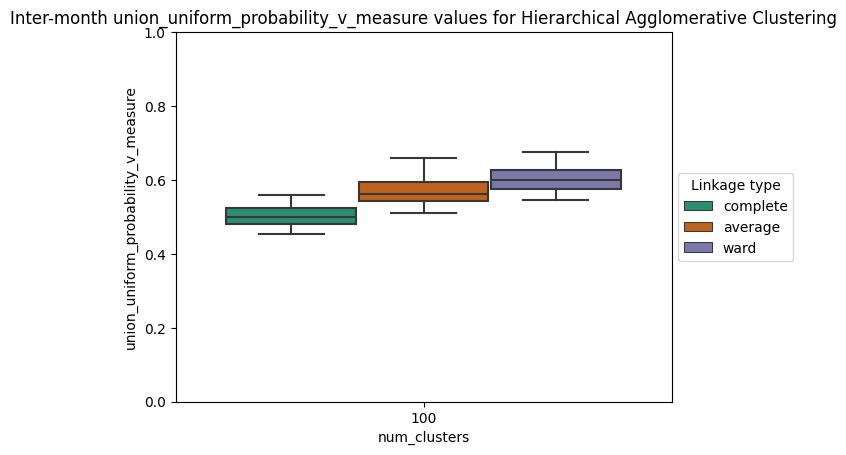

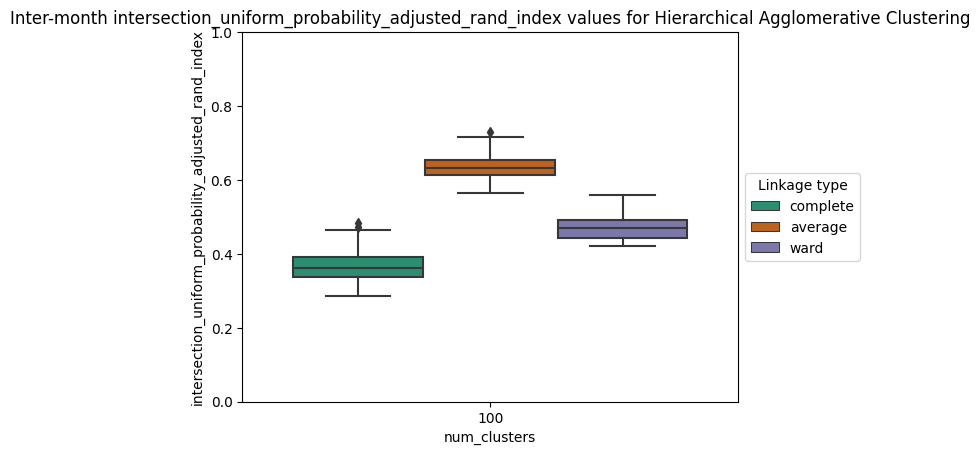

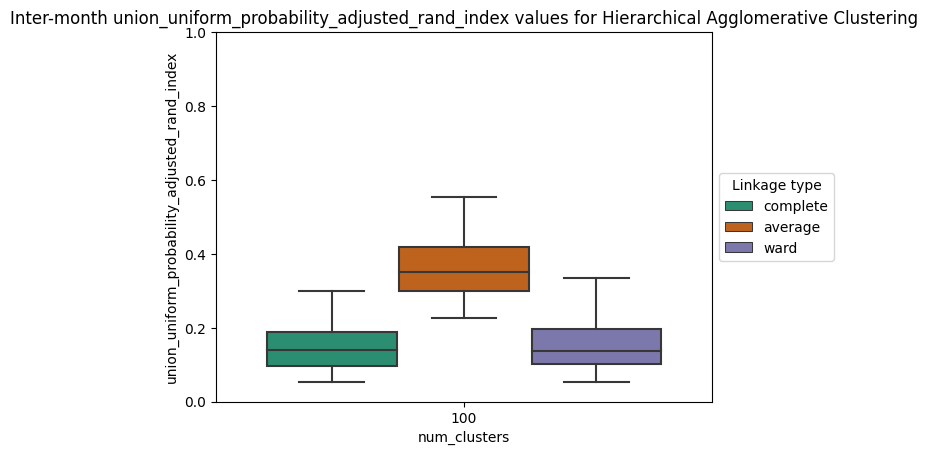

<Figure size 640x480 with 0 Axes>

In [19]:
hac_cluster_comparison_df = pd.read_csv(STABILITY_METRICS_ROOT / "hac_cluster_comparison_metrics.csv")
# For symmetric measures (everything except homogeneity and completeness), I'd like to get the average range over experiments 
month1s = list()
month2s = list()
for i, m1 in enumerate(MONTHS):
    for m2 in MONTHS[i+1:]:
        month1s.append(m1)
        month2s.append(m2)

month_filter = pd.DataFrame(data={"month1":month1s, "month2":month2s})
df_for_averages = pd.merge(month_filter, hac_cluster_comparison_df, how="left", on=["month1", "month2"])
display(df_for_averages)

# NMI and ARI are confusing me, what's the relation betwen them?
for prefix  in ["union", "intersection"]:

    ax = sns.scatterplot(data=df_for_averages, x=f"{prefix}_uniform_probability_adjusted_rand_index", y=f"{prefix}_uniform_probability_normalized_mutual_info", hue="num_clusters", style="linkage", legend="full", palette="Paired")
    ax.set(ylim=(0,1), xlim=(0,1))
    ax.set_title(f"Comparison between ARI and NMI for {prefix} uniform probability in inter-month comparison of Hierarchical Agglomerative Models")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.clf()


for metric in SYMMETRIC_METRICS:
    vmin = 0
    if "variation_of_information" in metric:
        # Max of VOI is 2 log K when C_1 and C_2 both have at most K* clusters
        if "intersection" in metric:
            vmax = 2*np.log2(max(NUM_CLUSTERS))
        elif "union" in metric:
            vmax = 2*np.log2(max(NUM_CLUSTERS) + 1)
    else:
        vmax=1
    ax = sns.boxplot(data=df_for_averages, y=metric, x="num_clusters", hue="linkage", order=NUM_CLUSTERS)
    ax.set_title(f"Inter-month {metric} values for Hierarchical Agglomerative Clustering")
    ax.set(ylim=(vmin, vmax))
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Linkage type")
    plt.show()
    plt.clf()


Linkage: complete Num Clusters: 100


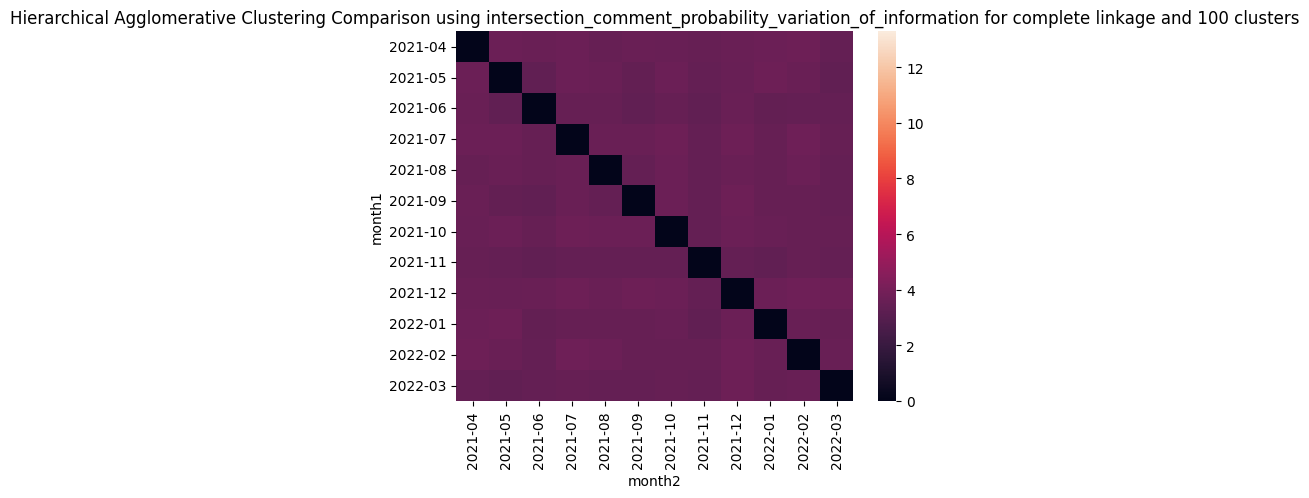

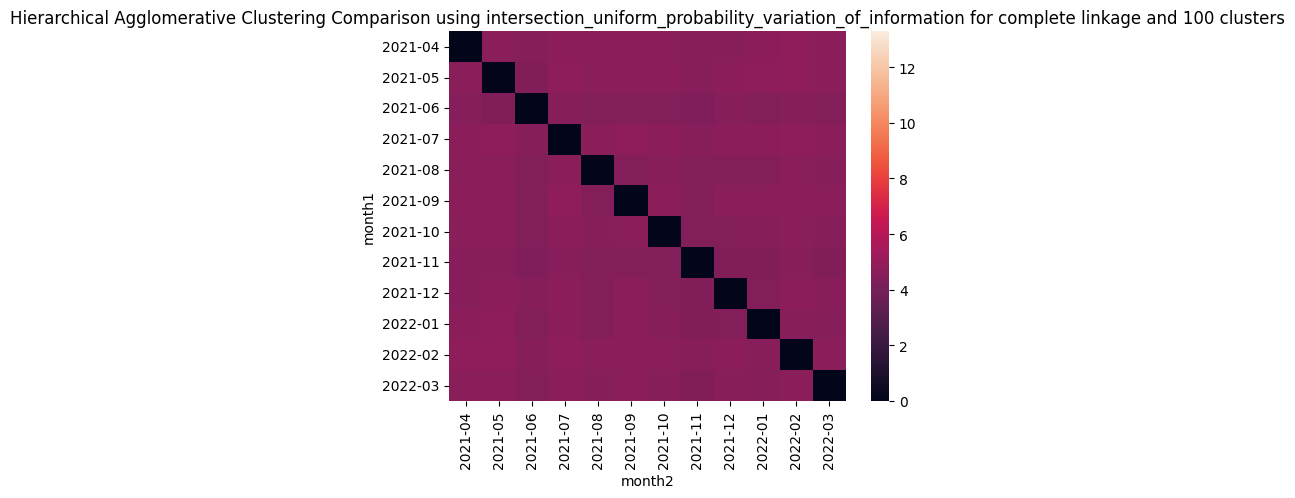

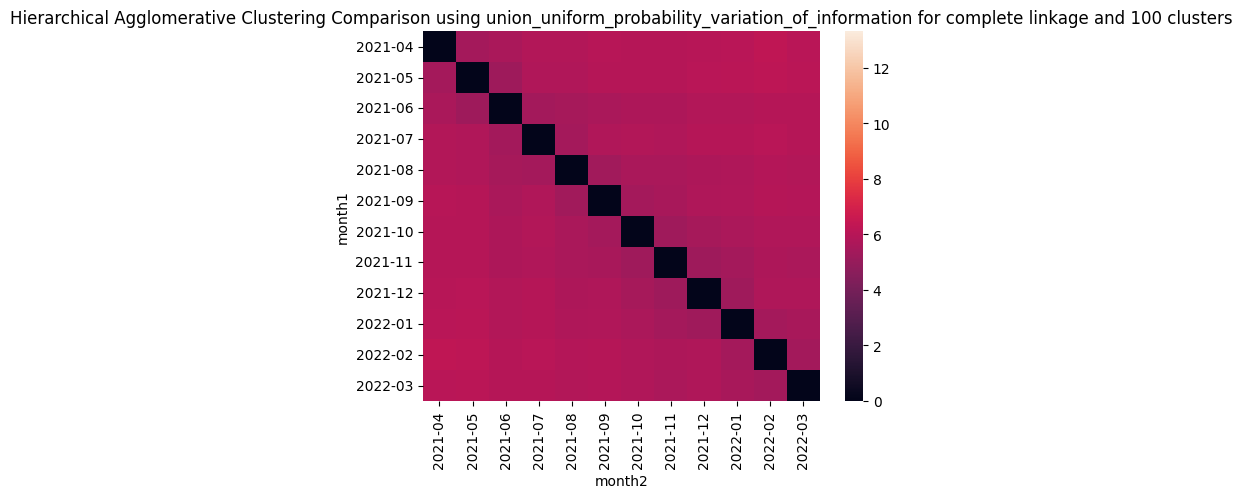

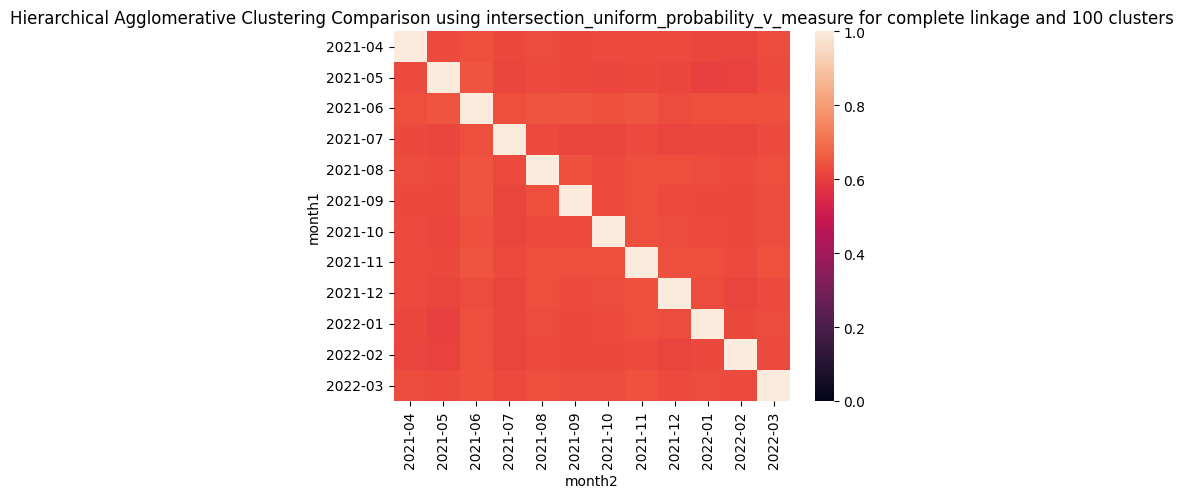

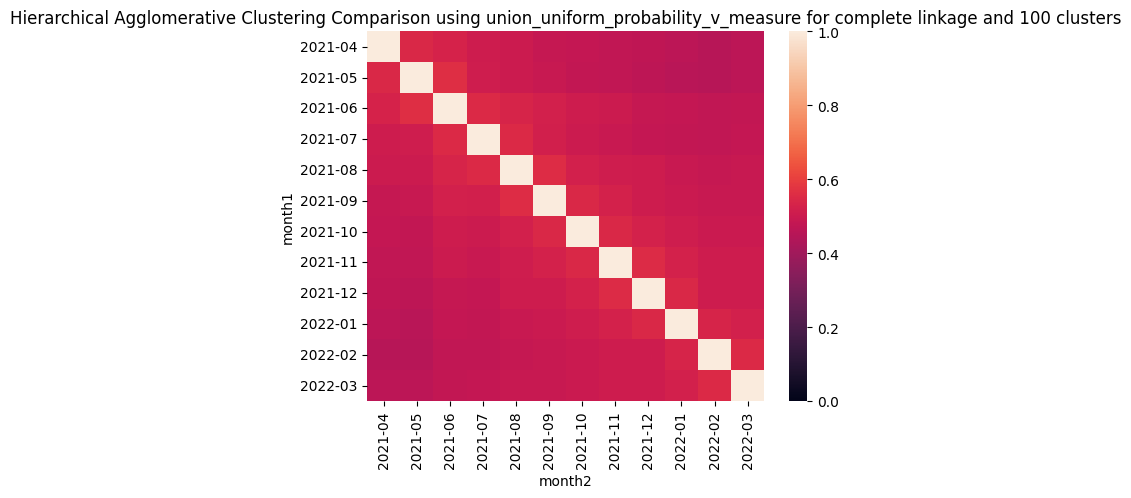

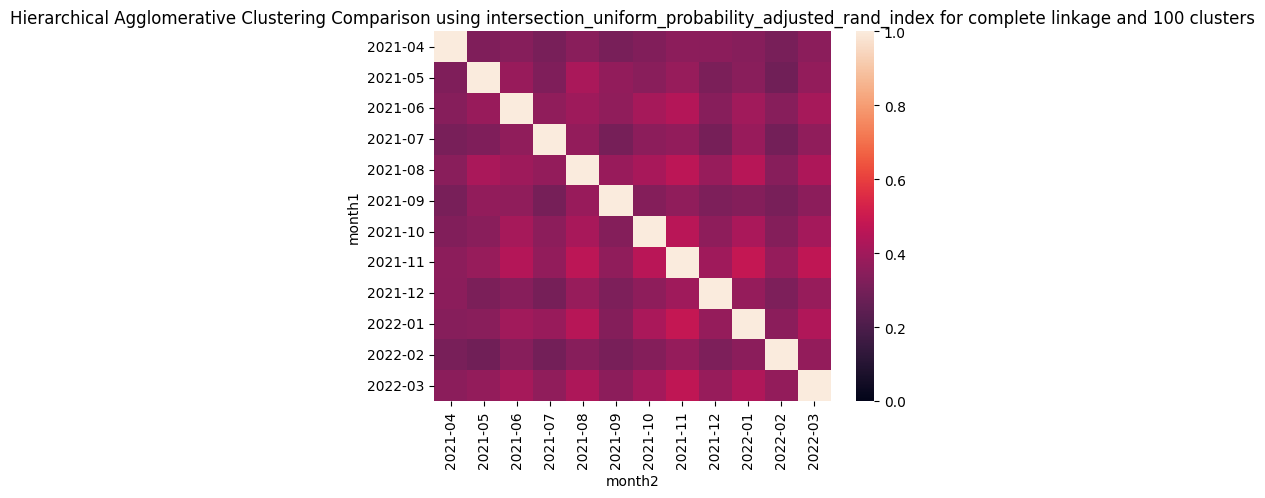

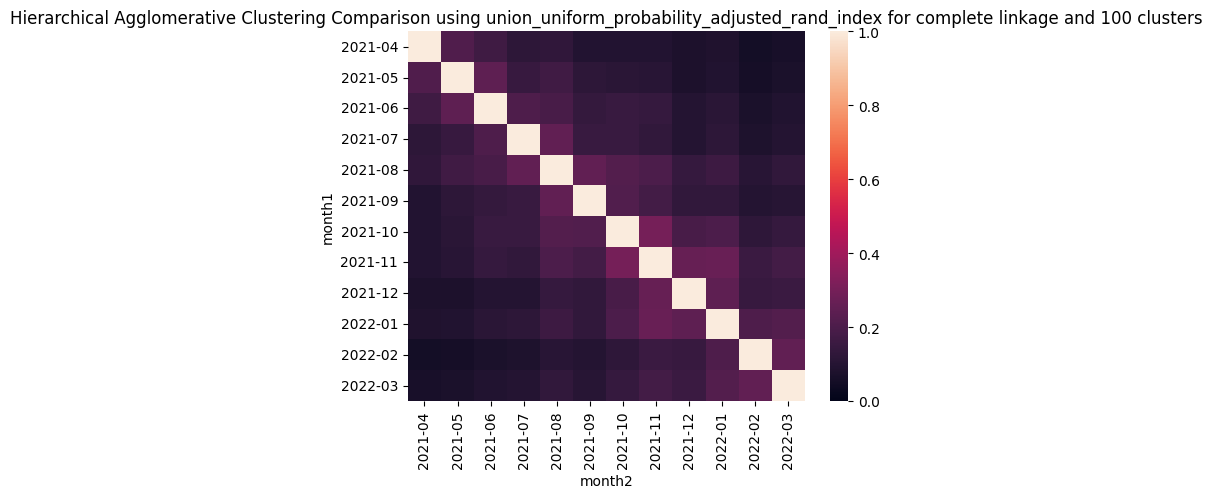

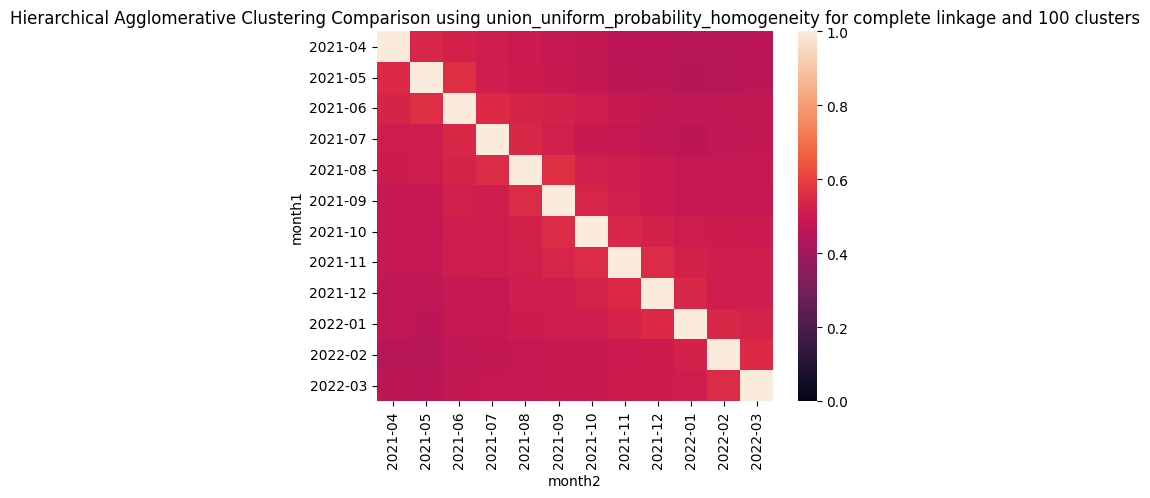

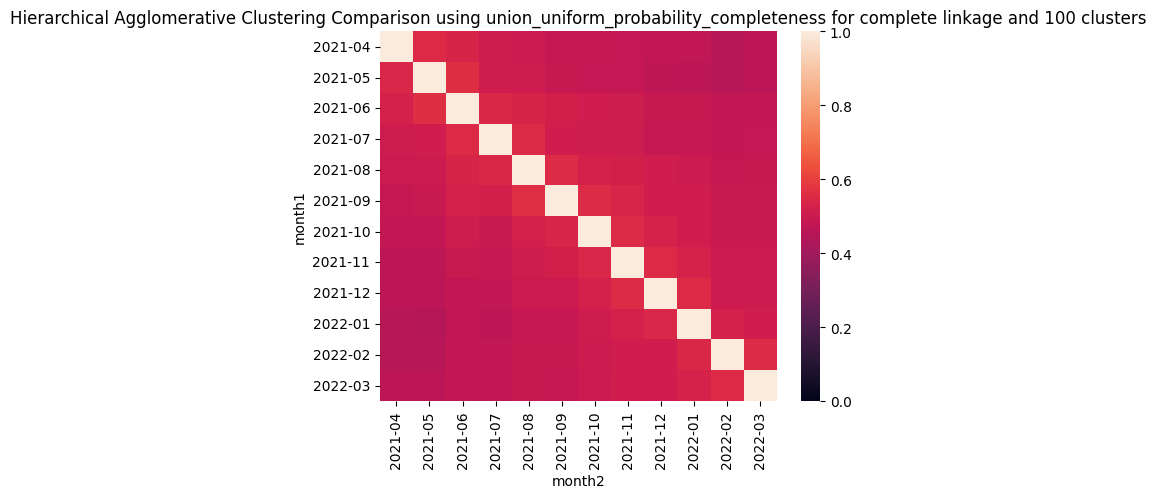

Linkage: average Num Clusters: 100


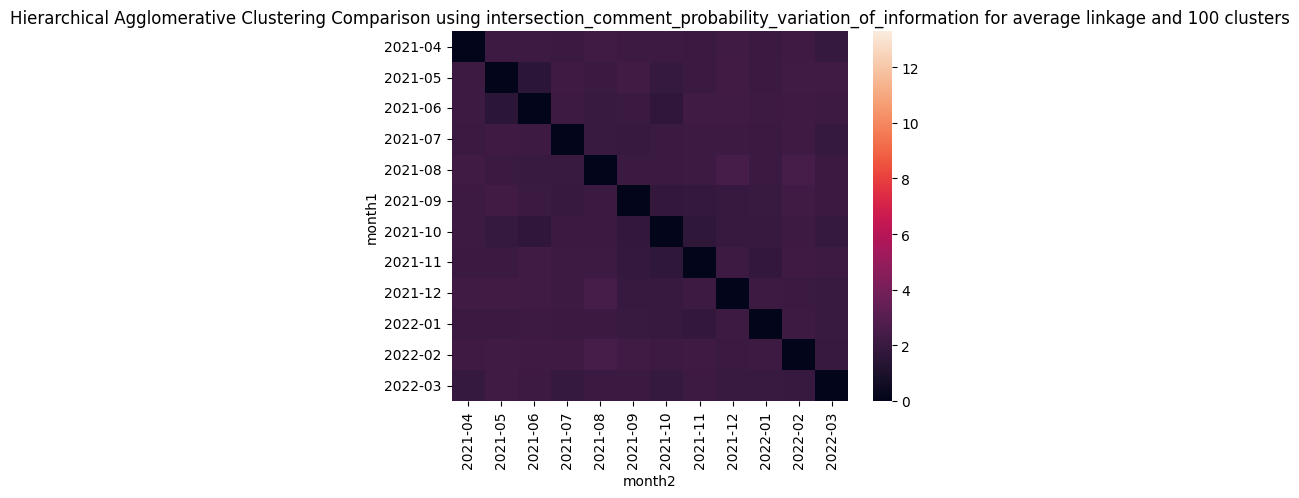

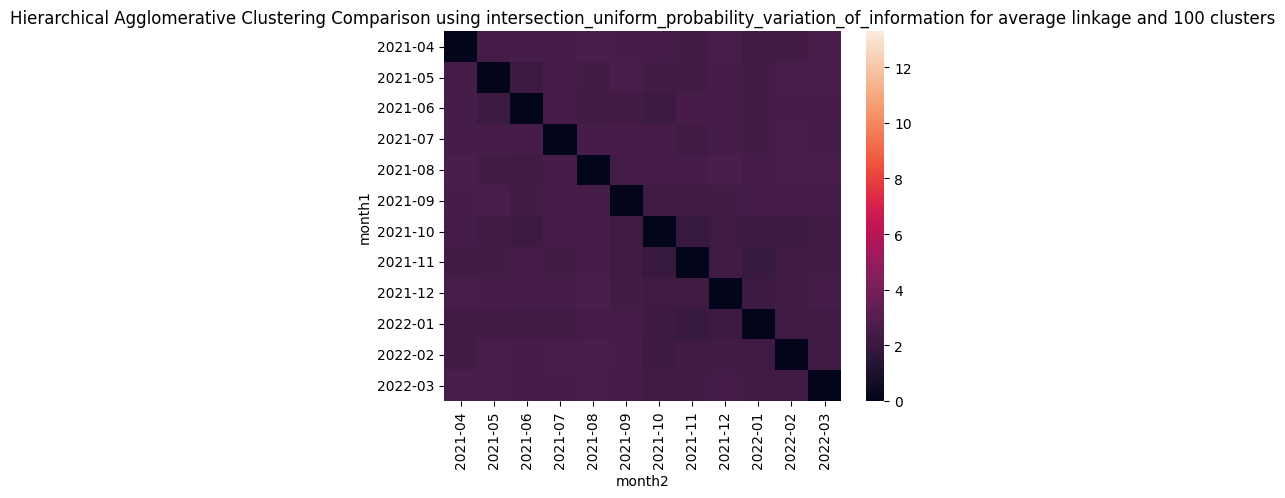

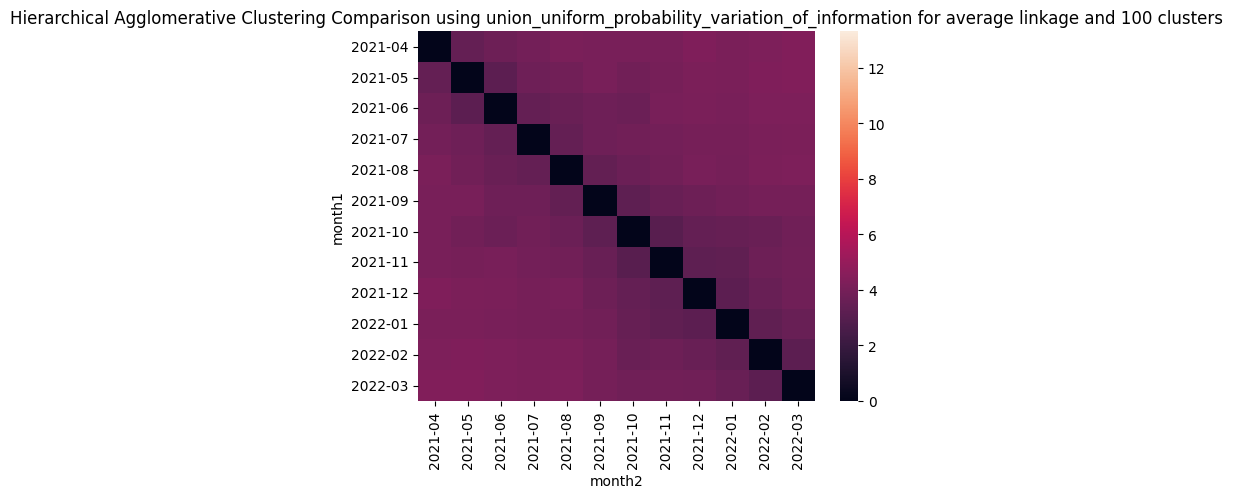

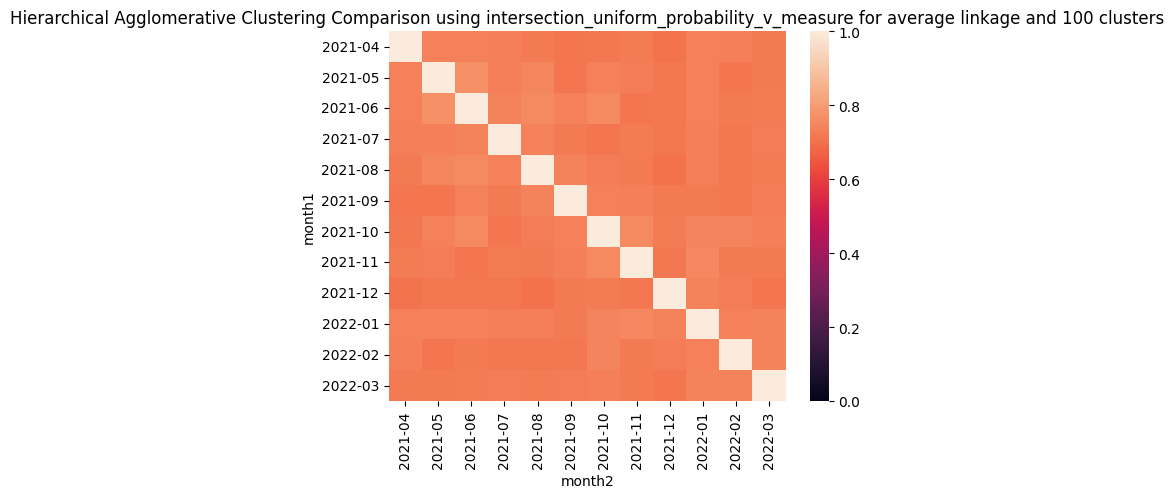

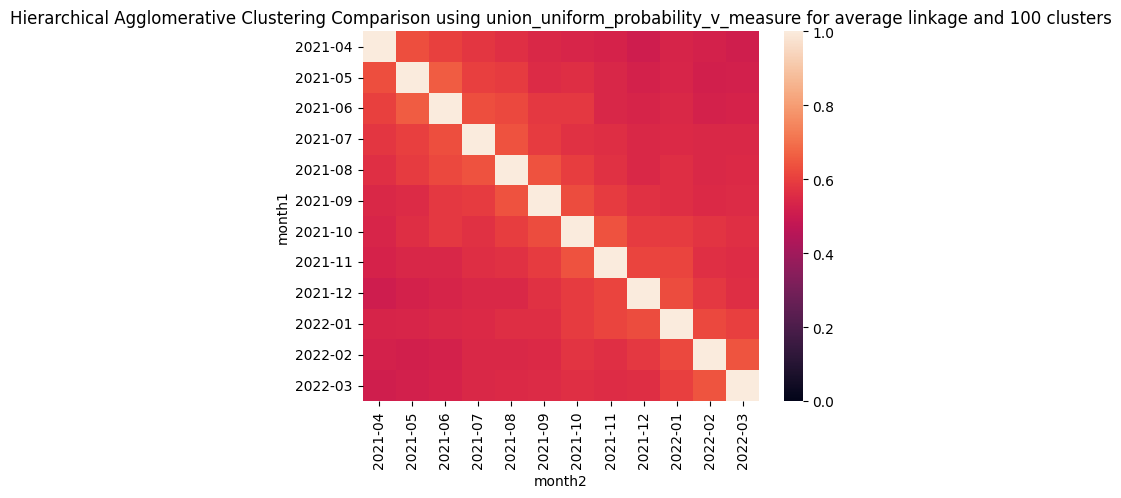

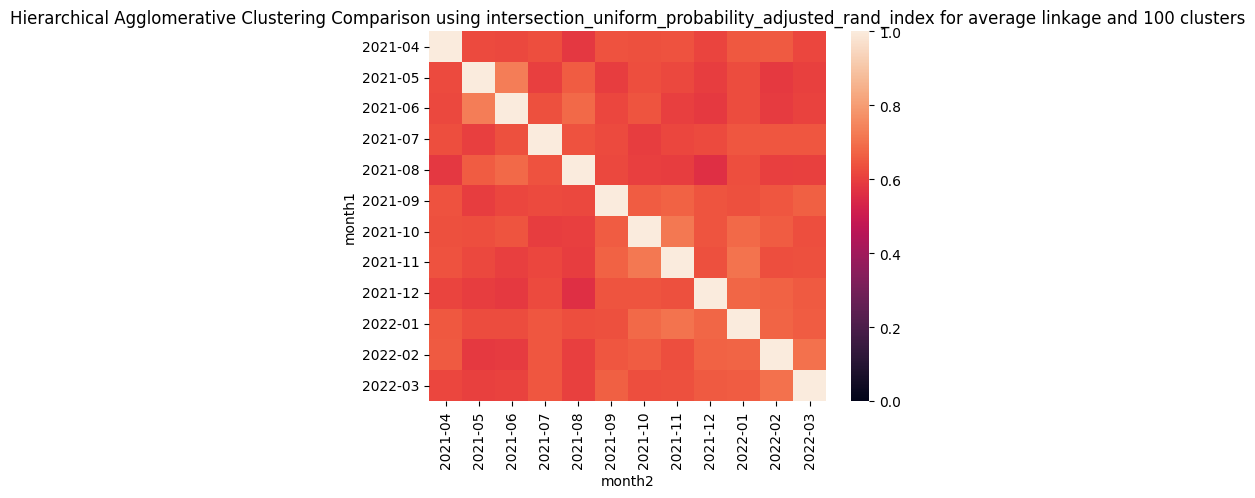

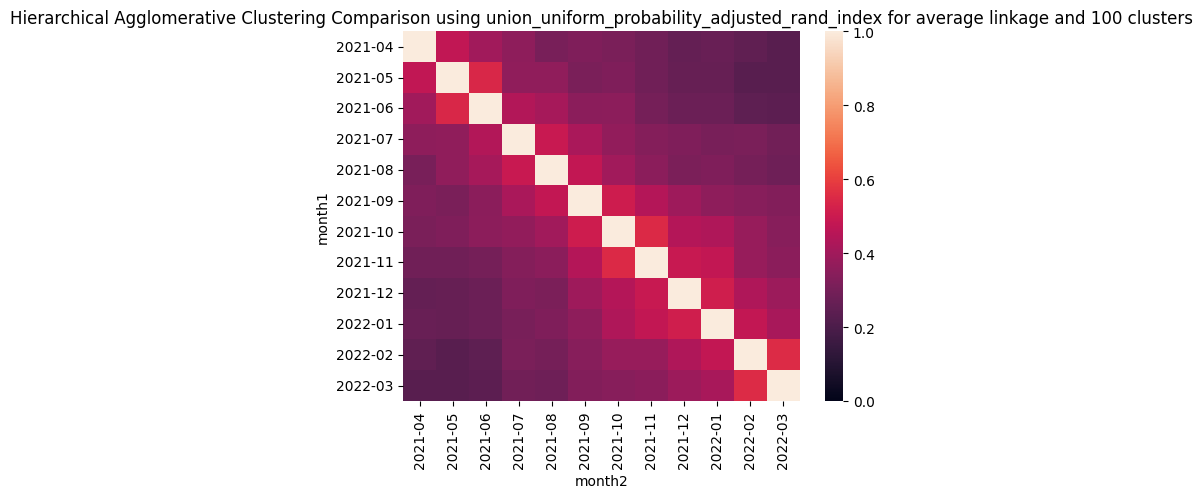

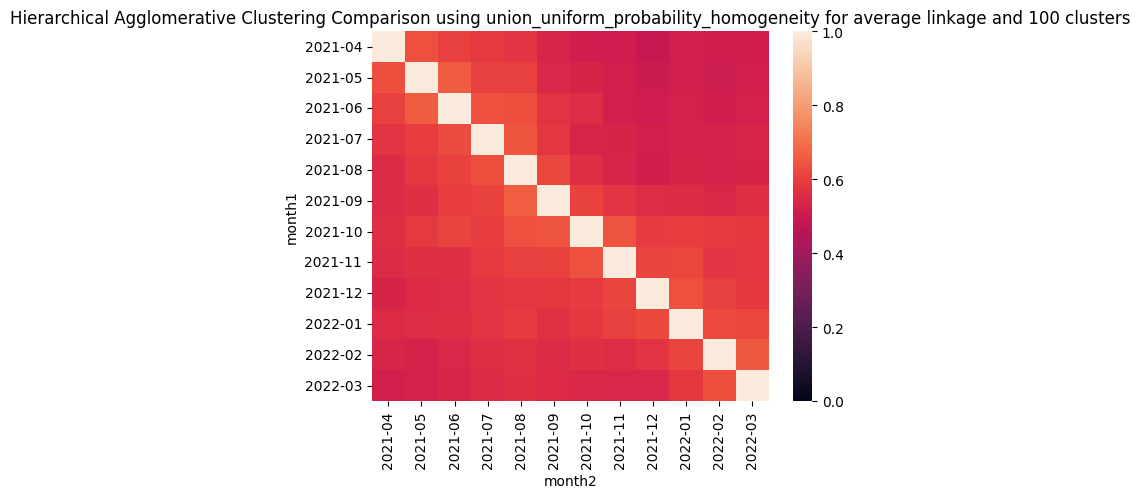

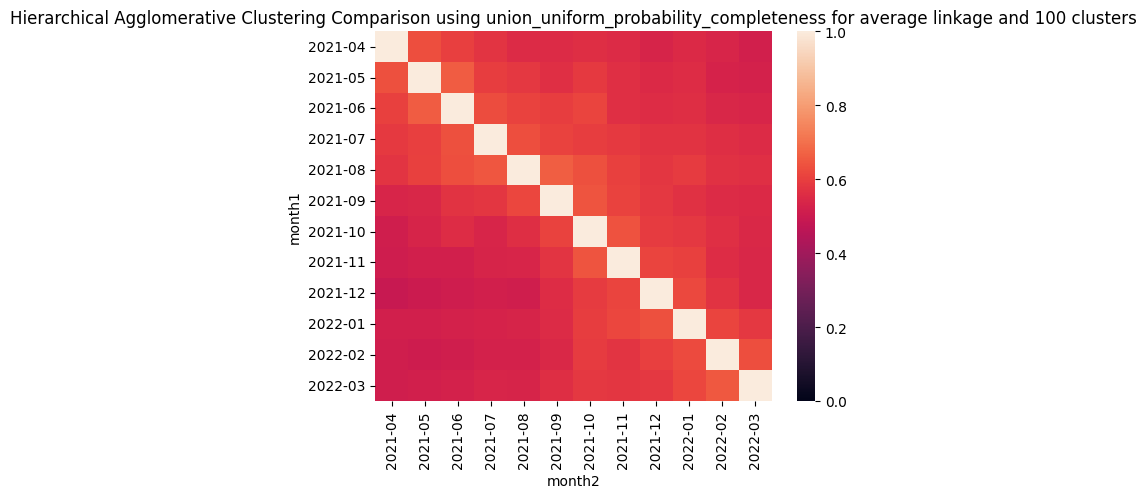

Linkage: ward Num Clusters: 100


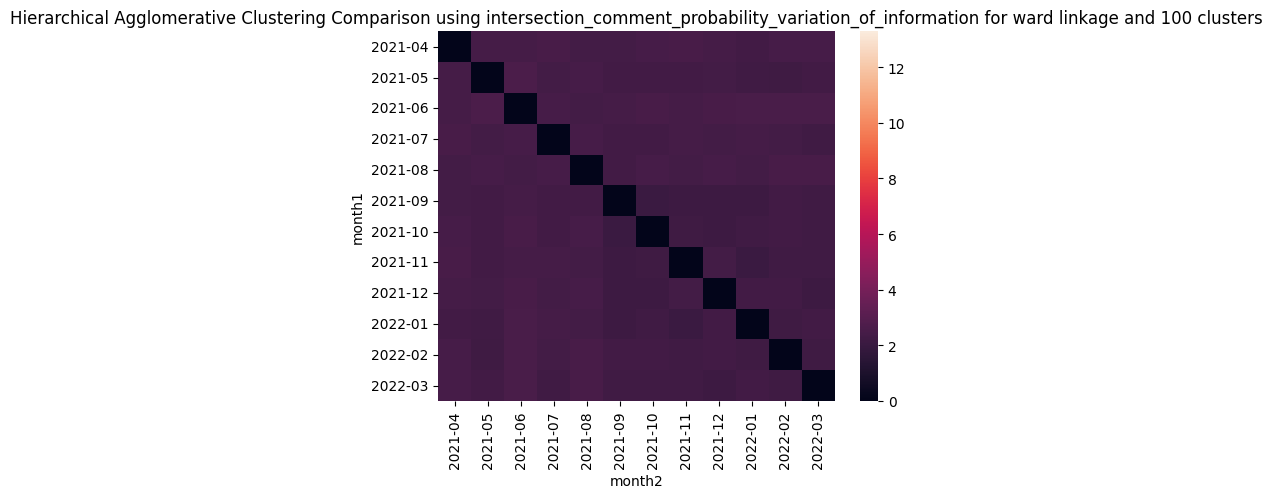

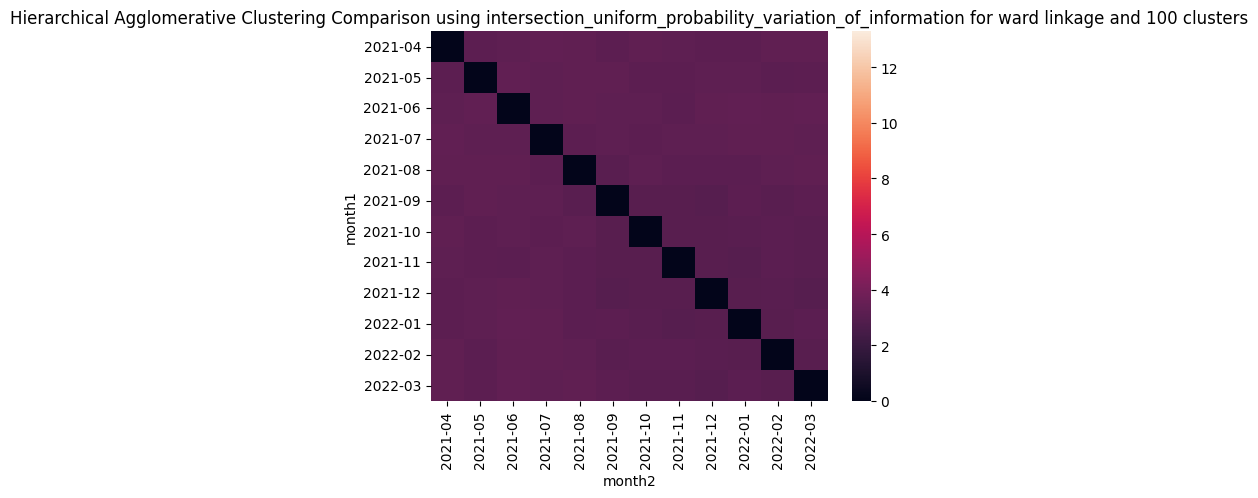

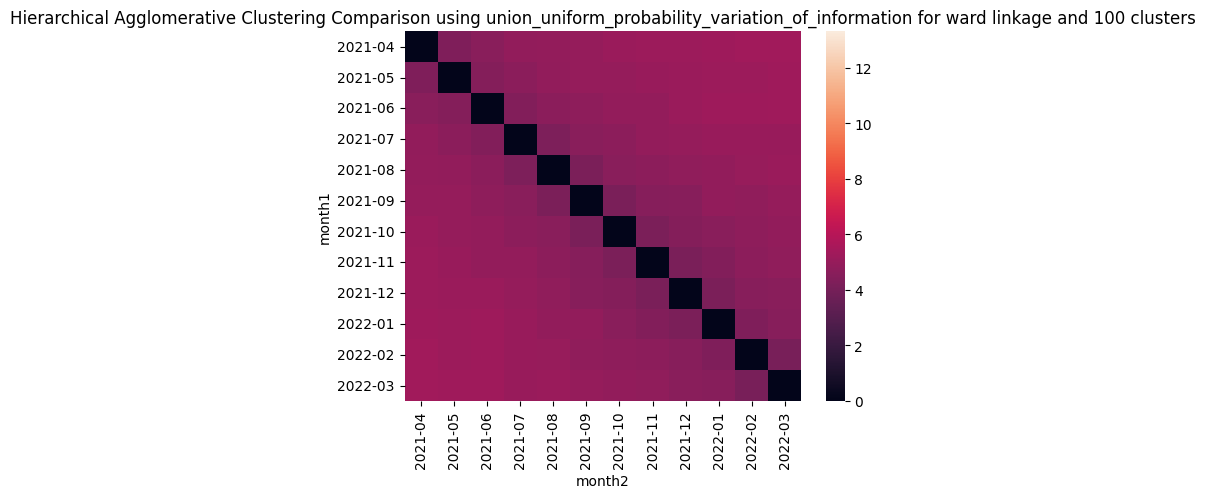

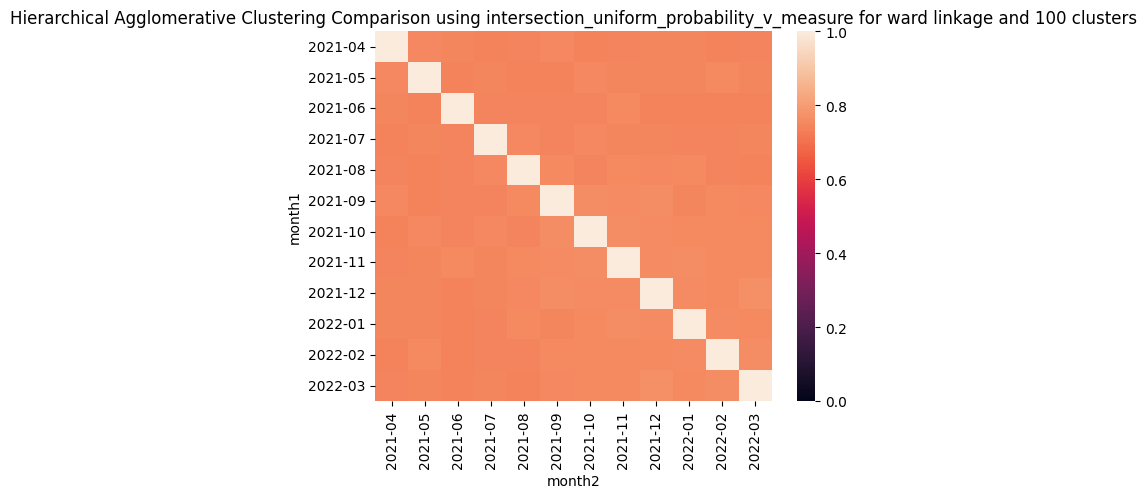

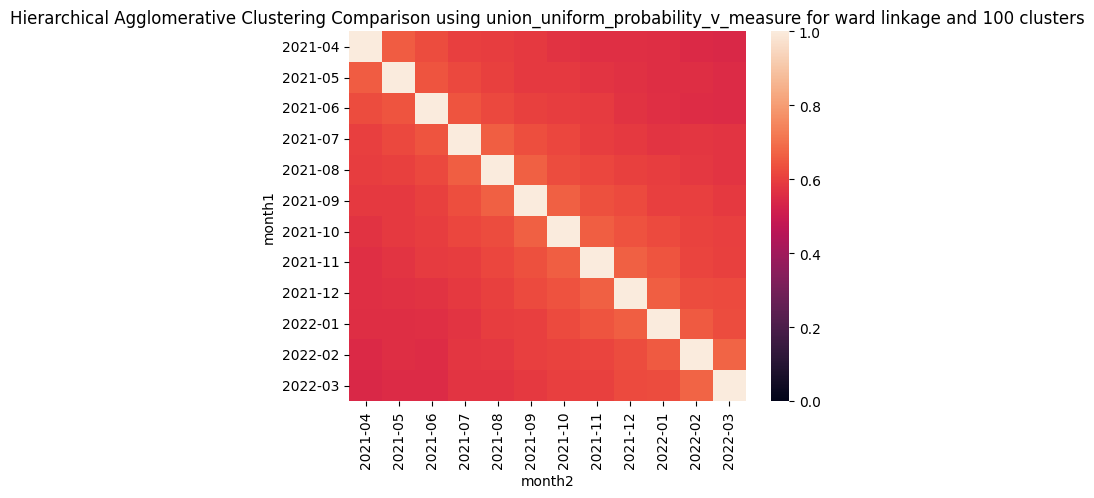

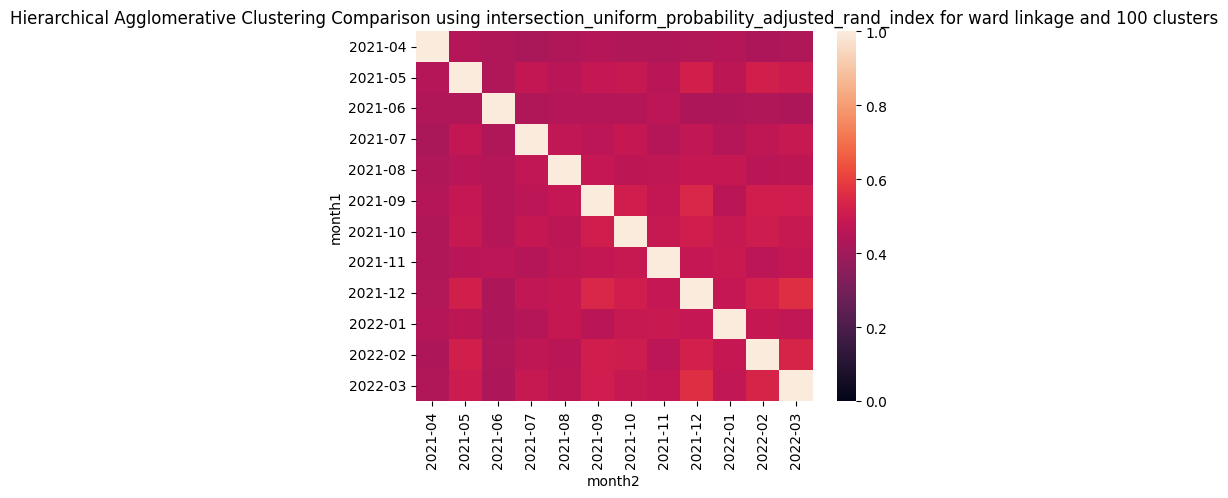

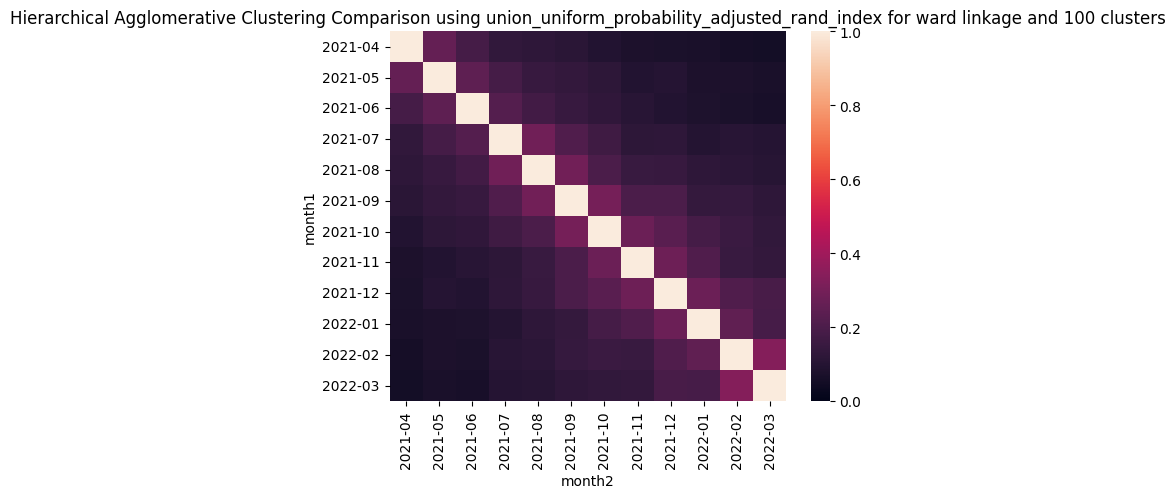

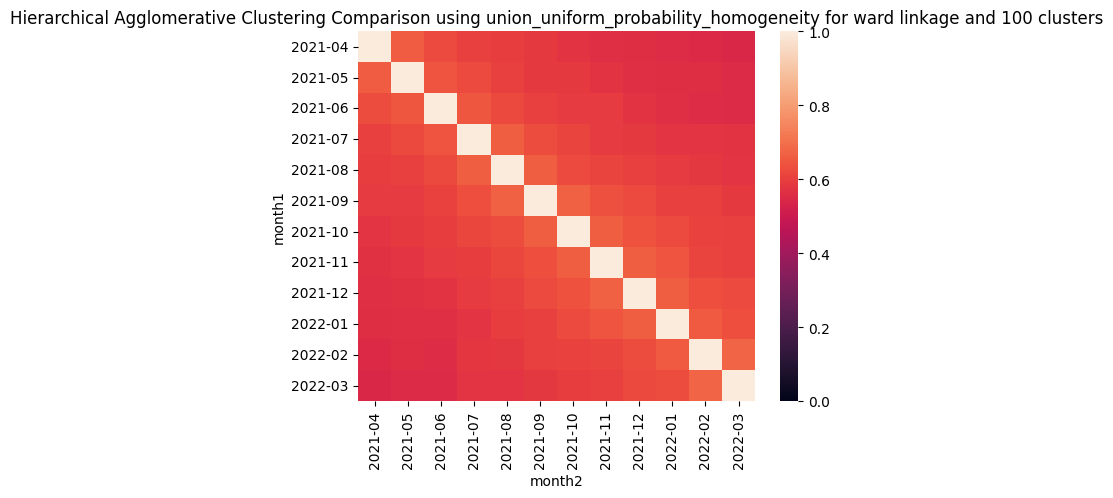

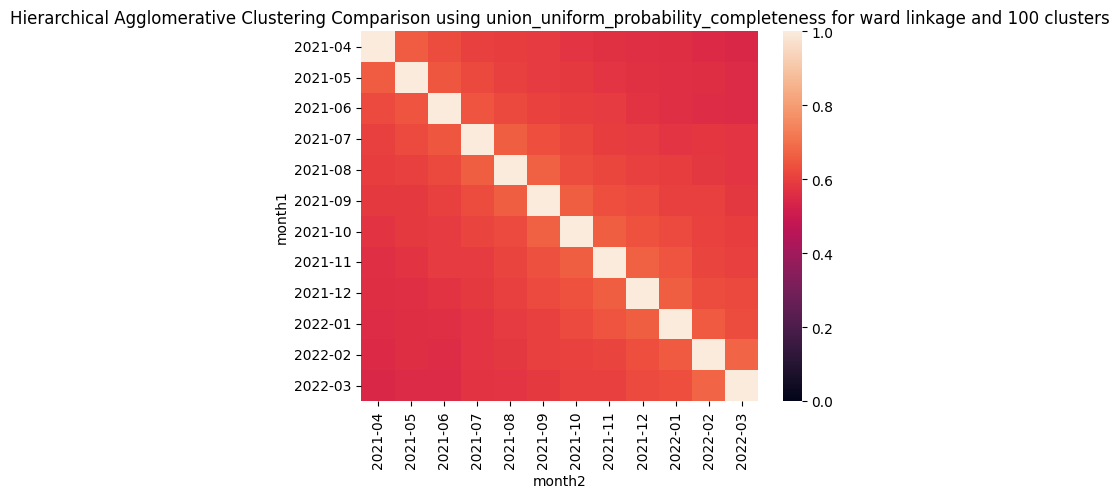

<Figure size 640x480 with 0 Axes>

In [20]:
for (l, n_clusters) in itertools.product(LINKAGE_TYPES, NUM_CLUSTERS):
    print("Linkage:", l, "Num Clusters:", n_clusters)
    for cluster_comp_metric in ALL_CLUSTER_COMP_METRICS:
        vmin = 0
        if "variation_of_information" in cluster_comp_metric:
            # Max of VOI is 2 log K when C_1 and C_2 both have at most K* clusters
            if "intersection" in cluster_comp_metric:
                vmax = 2*np.log2(n_clusters)
            elif "union" in cluster_comp_metric:
                vmax = 2*np.log2(n_clusters+1)
            
        else:
            vmax=1
        n_cluster_experiments = hac_cluster_comparison_df[(hac_cluster_comparison_df["linkage"] == l) & (hac_cluster_comparison_df["num_clusters"]==n_clusters)].copy()
        sns.heatmap(n_cluster_experiments.pivot_table(index="month1", columns="month2", values=cluster_comp_metric), vmin=vmin, vmax=vmax).set_title(f"Hierarchical Agglomerative Clustering Comparison using {cluster_comp_metric} for {l} linkage and {n_clusters} clusters")
        plt.show()
        plt.clf()